
# Data analysis

Purpose is:
 * To import & analyze "accounts.csv" file
 * To import & analyze "transactions.csv" file
 * To combine these data & compute useful informations for next month outgoing prediction

> At the end of this analysis, we should have
> * a quite clear **idea on how to build the prediction model**
> * prepare **tools** to help to do it

***

## Used libraries

 * Pandas will be used to import and explore data
 * Numpy will be used to compute some vectorial operations
 * Matplotlib will be used to visualize data

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

***

## Import & Analysis of "accounts.csv"


In [2]:
accounts = pd.read_csv("data/accounts.csv")
accounts.head()

id  balance update_date
0   0    13.63  2021-07-02
1   1    12.91  2021-07-02
2   2    19.84  2021-07-02
3   3   130.00  2021-07-02
4   4  2806.75  2021-07-02

In [3]:
print("Number of rows: ", len(accounts.index))
print("Data types:")
print(accounts.dtypes)

Number of rows:  1254
Data types:
id               int64
balance        float64
update_date     object
dtype: object


In [4]:
#Conversion of update_date to date format
accounts.loc[:,'update_date'] = pd.to_datetime(accounts.update_date,format="%Y-%m-%d")
print(accounts.dtypes)

id                      int64
balance               float64
update_date    datetime64[ns]
dtype: object


In [5]:
print("Is there duplicated account ? ",any(accounts.duplicated(subset=['id'])))

Is there duplicated account ?  False


> "accounts.csv" gives the balance value of 1254 unique accounts, at a given date
>> As there is only unique accounts, there is no need to select the last update date for a given account


### Some graphics

We propose to visualize the balance at update date, for all the accounts, and its distribution: do you have to deal with a large diversity ?

In [6]:
accounts.balance.describe()

count      1254.000000
mean       2495.186994
std       11853.402866
min      -98240.370000
25%           1.132500
50%          72.065000
75%        1083.257500
max      216975.660000
Name: balance, dtype: float64

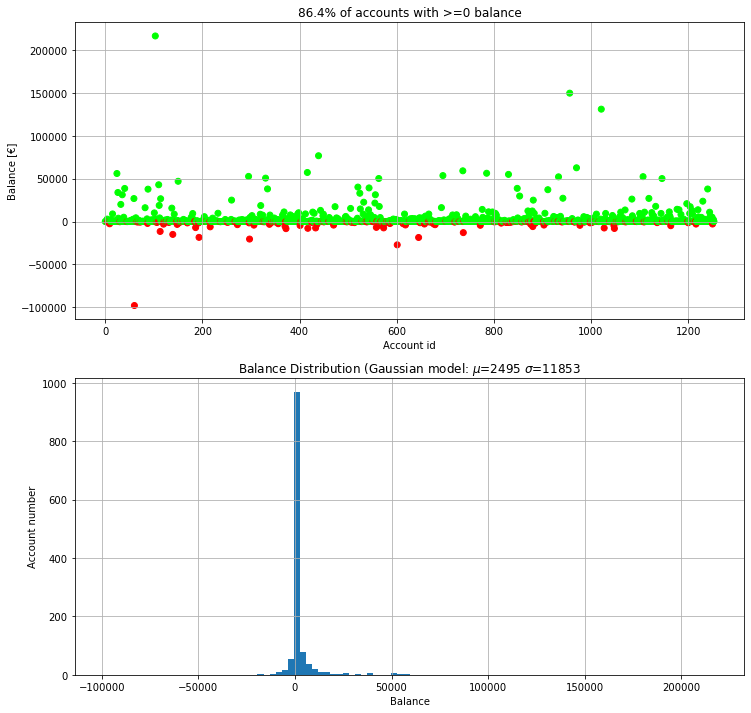

In [7]:
#Plot of accounts balance (green = positive balance ; red = negative balance) & their distribution
clr_rgb=np.zeros(shape=(len(accounts.id),3)) #Initialization of (R,G,B) colors for all accounts
clr_rgb[accounts.balance>=0,:]=np.array([0,1,0]) #Balance >=0 => Green
clr_rgb[accounts.balance<0,:]=np.array([1,0,0]) #Balance <0 => Red
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.grid()
plt.scatter(accounts.id,accounts.balance,c=clr_rgb)
plt.xlabel("Account id"),plt.ylabel("Balance [€]")
plt.title("{:.1%} of accounts with >=0 balance".format(len(np.where(accounts.balance>=0)[0])/len(accounts.index)))
plt.subplot(2,1,2)
plt.grid()
plt.hist(accounts.balance,bins=100)
plt.title("Balance Distribution (Gaussian model: $\mu$={:.0f} $\sigma$={:.0f}".format(accounts.balance.mean(),accounts.balance.std()))
plt.xlabel("Balance"),plt.ylabel("Account number")
plt.show()

> Accounts are quite similar, and equilibrated around 0 (median balance : 72 €). There should not be necessary to categorize them

***

## Import & Analysis of "transactions.csv"


In [8]:
transactions = pd.read_csv("data/transactions.csv")
transactions.head()

account_id        date  amount
0           0  2020-10-16   200.0
1           0  2020-10-16  -192.0
2           0  2020-10-16   200.0
3           0  2020-10-16   -24.0
4           0  2020-10-16   -50.0

In [9]:
print(transactions.head())
print("Number of rows: ", len(transactions.index))
print("Data types:")
print(transactions.dtypes)

   account_id        date  amount
0           0  2020-10-16   200.0
1           0  2020-10-16  -192.0
2           0  2020-10-16   200.0
3           0  2020-10-16   -24.0
4           0  2020-10-16   -50.0
Number of rows:  518229
Data types:
account_id      int64
date           object
amount        float64
dtype: object


In [10]:
#Conversion of date to date format
transactions.loc[:,'date'] = pd.to_datetime(transactions.date,format="%Y-%m-%d")
print(transactions.dtypes)

account_id             int64
date          datetime64[ns]
amount               float64
dtype: object


In [11]:
print("Number of accounts: ", len(transactions.account_id.unique()))
print("There is {} null transactions".format(len(transactions[transactions.amount==0].index)))
print("Number of accounts without transactions: {}".format(len(transactions.account_id.unique())-len(transactions[transactions.amount!=0].account_id.unique())))

Number of accounts:  1254
There is 10532 null transactions
Number of accounts without transactions: 2


> "transactions.csv" gives the transactions history of 1254 accounts
> Some transactions are null, but we keep them because they are a part of history. As an example, 2 accounts have no transactions (i.e. only null transactions)


### Some graphics

We propose to visualize the amounts of transactions, depending on account balance, and their distribution: do you have to deal with a large diversity ?

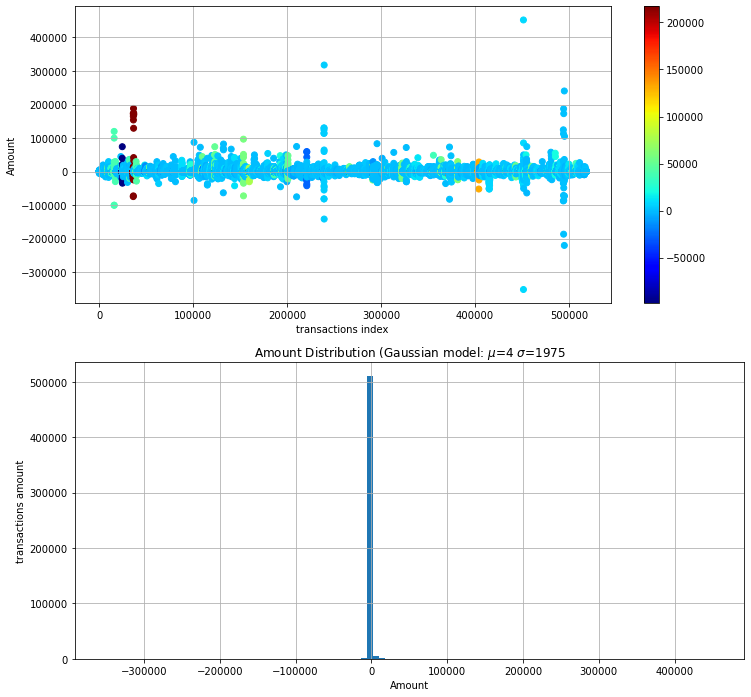

In [12]:
#Plot of transactions amount (green = income ; red = outgoing)
clr_rgb=np.zeros(shape=(len(transactions.index),3)) #Initialization of (R,G,B) colors for all transactions
clr_rgb[transactions.amount>=0,:]=np.array([0,1,0]) #Balance >=0 => Green
clr_rgb[transactions.amount<0,:]=np.array([1,0,0]) #Balance <0 => Red
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.grid()
plt.scatter(transactions.index,transactions.amount,cmap="jet",c=accounts.balance.loc[transactions.account_id])
plt.colorbar()
plt.xlabel("transactions index"),plt.ylabel("Amount")
plt.subplot(2,1,2)
plt.grid()
plt.hist(transactions.amount,bins=100)
plt.title("Amount Distribution (Gaussian model: $\mu$={:.0f} $\sigma$={:.0f}".format(transactions.amount.mean(),transactions.amount.std()))
plt.xlabel("Amount"),plt.ylabel("transactions amount")
plt.show()

> Transactions are quite equally distributed around 0: there should be correlation between income & outgoing.
> Moreover, big transactions are not specifically related to account balance: it should not be necessary to use last account balance as a parameter of the prediction model

***

## Combine accounts & transactions data, and compute useful informations for next month outgoing prediction



### Creating function ```account_info``` which:

 * Combines accounts & transactions data, for a given account
 * Computes balance history, based on transactions
 * Computes cumulated income & outgoing versus time
 * Creates a summary visualization

In [13]:
def account_info(transactions, accounts, my_id, debug_mode = False):
    '''
    Return the account history as a DataFrame: date / transaction amount / balance / cumulated outgoing (converted to positive value) / cumulated income
    '''
    
    #Extracting account info (referenced by id my_id)
    my_account=accounts[accounts.id==my_id]
    
    #Extracting transactions of given account 
    my_transactions=transactions[transactions.account_id==my_id].copy()
    my_transactions.drop(columns=['account_id'],inplace=True) #Removing accountçid column
    my_transactions=my_transactions.sort_values(by="date", ascending=False)
    nb_trans=len(my_transactions.index) #Number of transactions
    
    
    #Initialization of account history
    account_history=pd.DataFrame(data={'date':[my_account.update_date.iloc[0]],
                                      'amount':[0],
                                      'balance':[my_account.balance.iloc[0]],
                                      'outgoing_cumsum':[0],
                                      'income_cumsum':[0]})
    if nb_trans>0:
        account_history=pd.concat([account_history,my_transactions],ignore_index=True)
        
        #Calculating balance column
        account_history.loc[1:nb_trans,'balance']=account_history.balance.iloc[0]-pd.Series(np.array(account_history.amount.iloc[0:nb_trans-1].cumsum()),account_history.iloc[1:nb_trans].index) #balance history

        #Calculating cumulated outgoing column
        account_history.loc[:,'outgoing_cumsum']=0 #initialization
        account_history.outgoing_cumsum=pd.Series(np.array(account_history.amount.iloc[::-1].apply(lambda x:-min(0,x)).cumsum()),account_history.iloc[::-1].index) #cumulated outgoing

        #Calculating cumulated income
        account_history.loc[:,'income_cumsum']=0 #initialization
        account_history.income_cumsum=pd.Series(np.array(account_history.amount.iloc[::-1].apply(lambda x:max(0,x)).cumsum()),account_history.iloc[::-1].index) #cumulated income

        
    #Displaying some useful data
    if debug_mode:
        plt.figure(figsize=(12,6))
        ax1=plt.axes()
        ax1.plot(account_history.date,account_history.balance,'b+-')
        ax1.set_xlabel("Date"), ax1.set_ylabel("Balance [€]",color="b")
        ax1.tick_params(axis='y', color='b', labelcolor='b')
        
        ax2 = ax1.twinx()
        ax2.plot(account_history.date,account_history.outgoing_cumsum,'r+-',label="Cumulated outgoing")
        ax2.plot(account_history.date,account_history.income_cumsum,'g+-',label="Cumulated income")
        ax2.set_ylabel("Cumulated income / outgoing [€]")
        ax2.legend()
        ax2.spines["left"].set_color("b")
        
        plt.title("Account #{:d}: {:.2f}€ @{} - {:d} days of history".format(my_id,
                                                                             account_history.balance.iloc[0],
                                                                             my_account.update_date.iloc[0].strftime('%Y-%m-%d'),
                                                                             (account_history.date.max()-account_history.date.min()).days))
        plt.show()
        
    return account_history

*Example on 100 first accounts:*

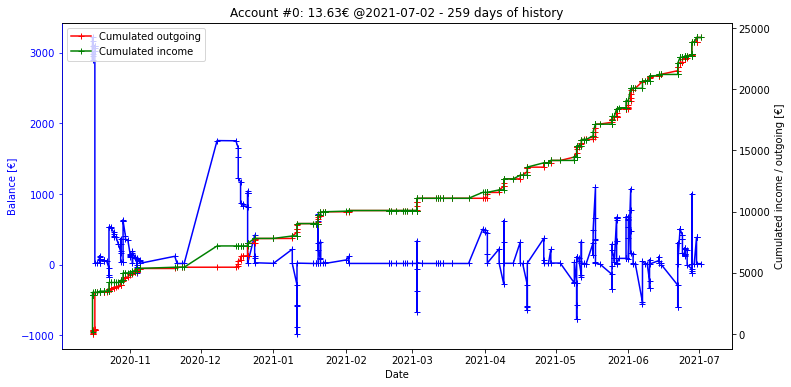

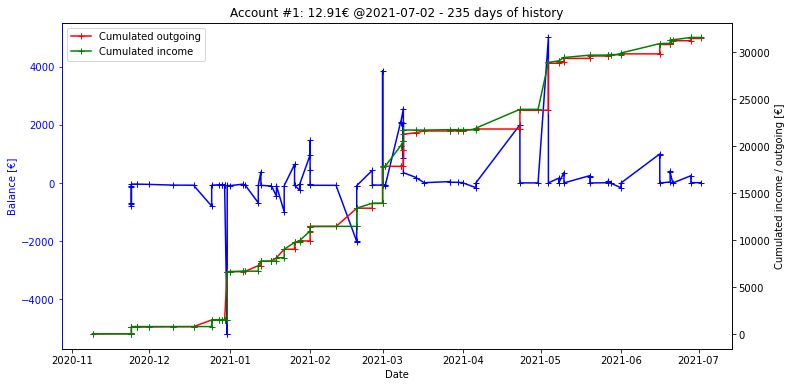

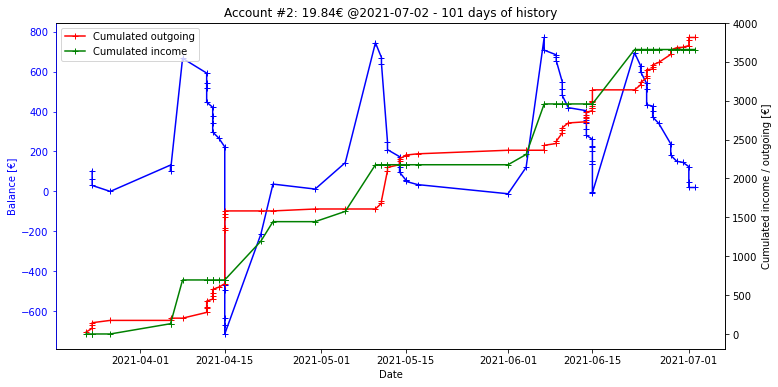

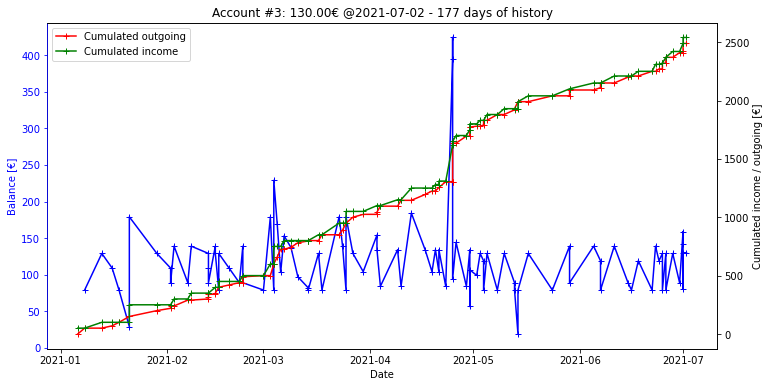

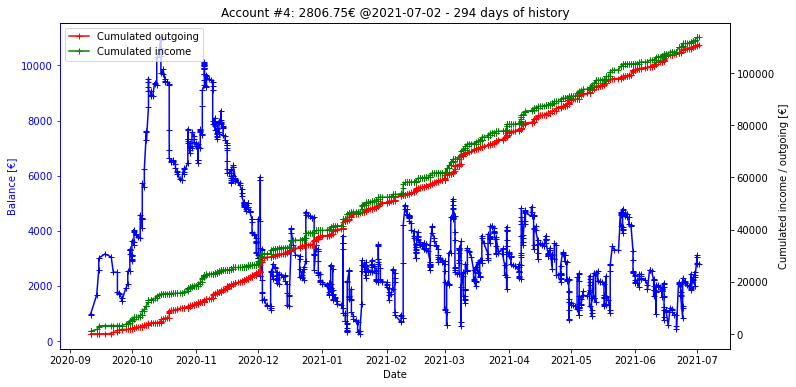

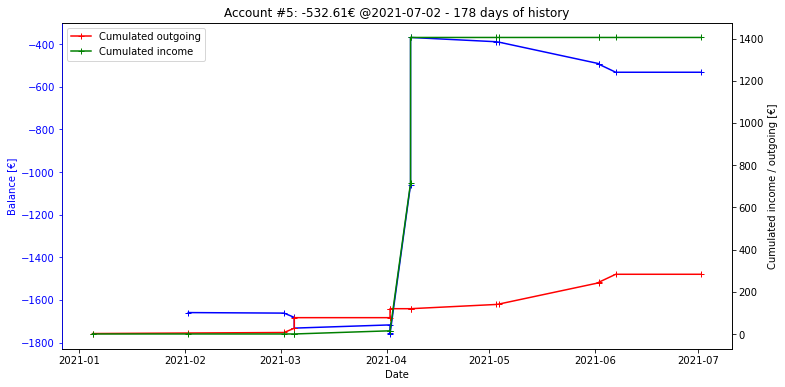

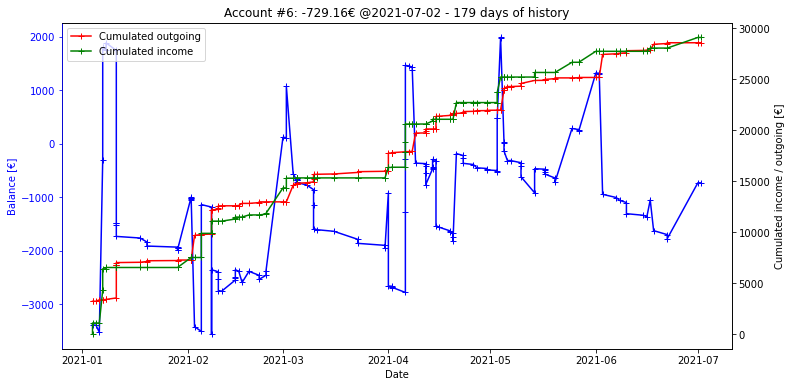

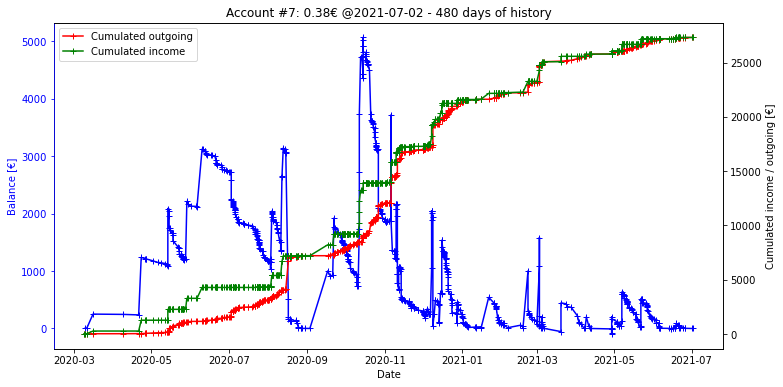

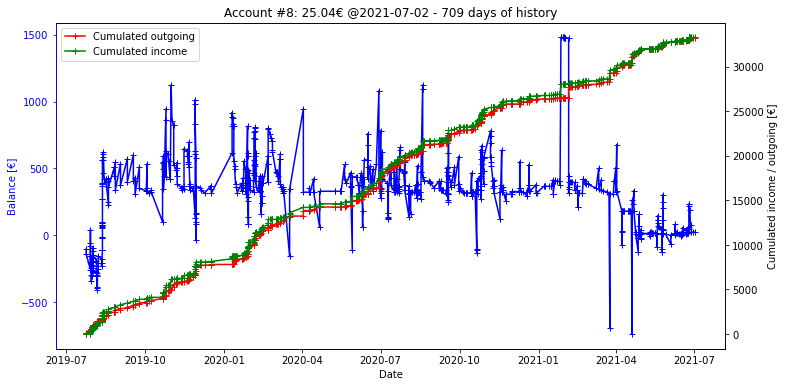

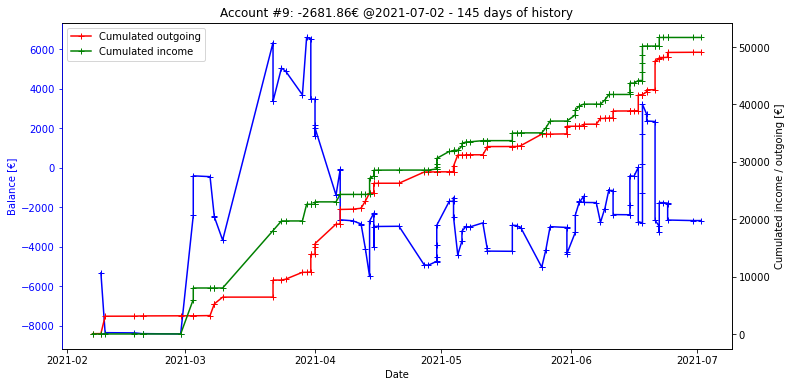

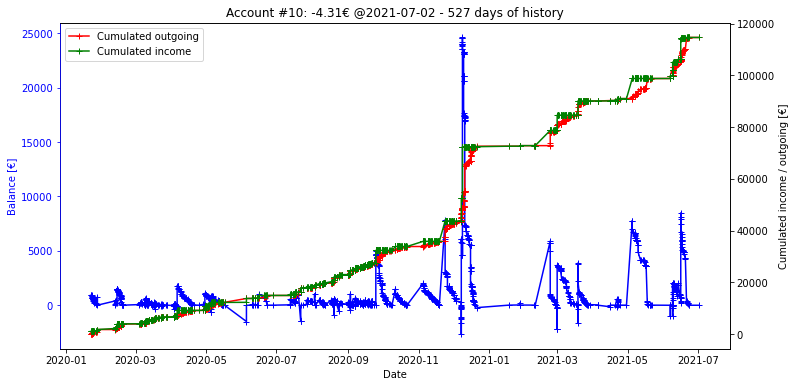

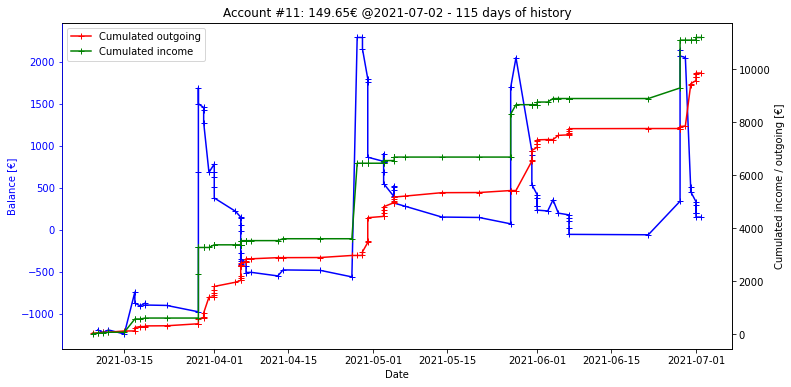

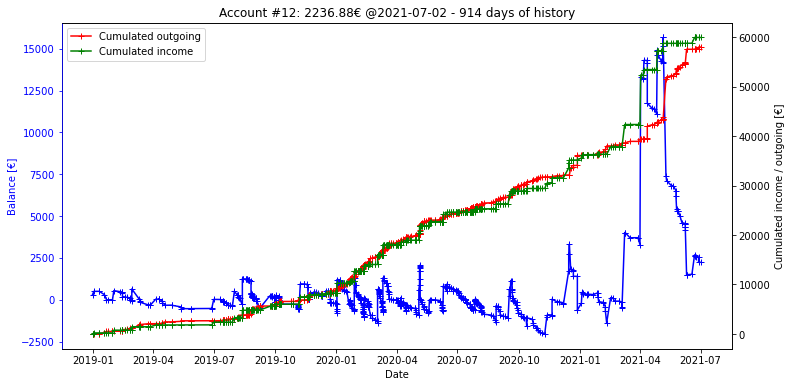

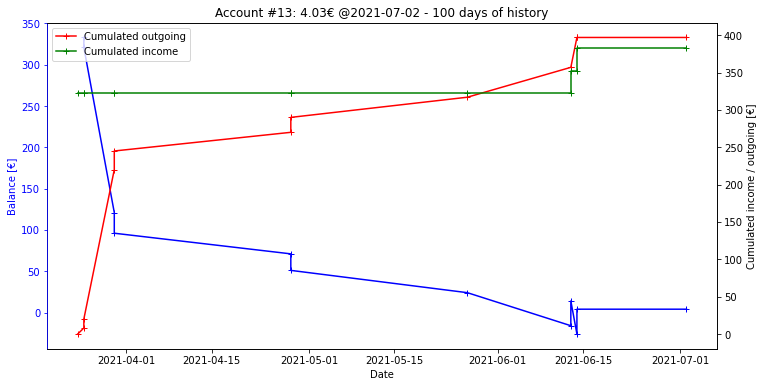

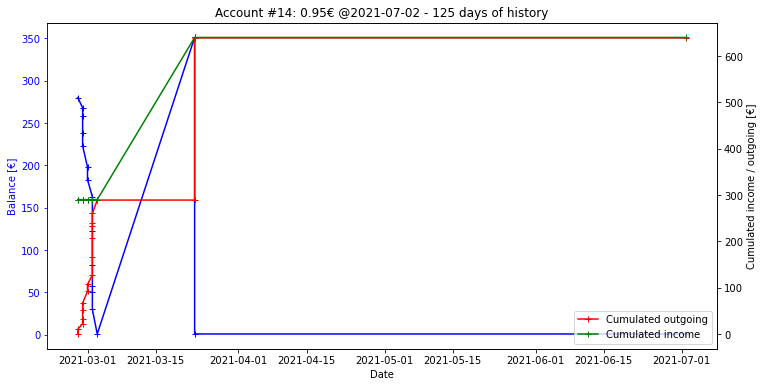

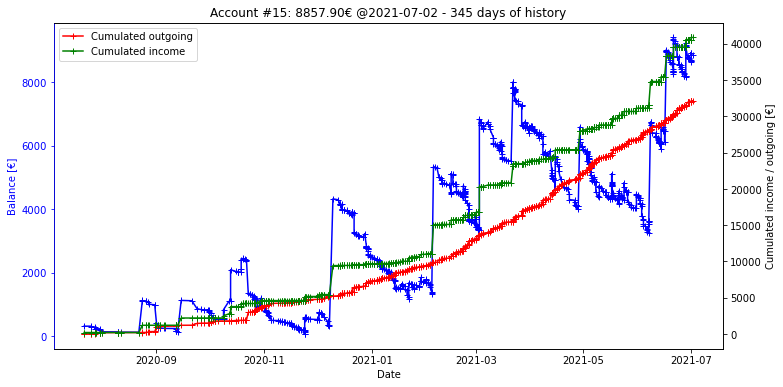

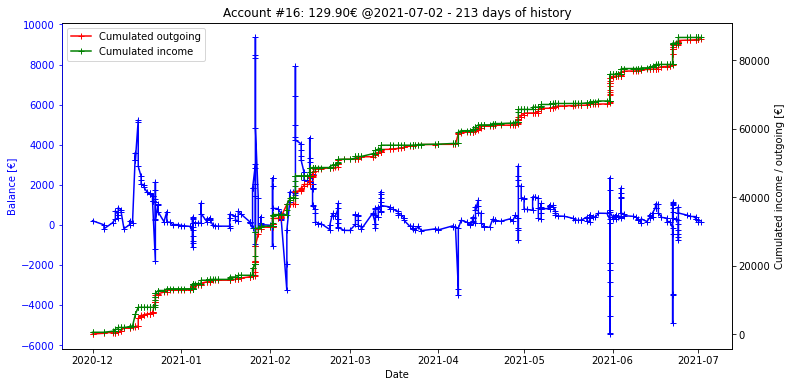

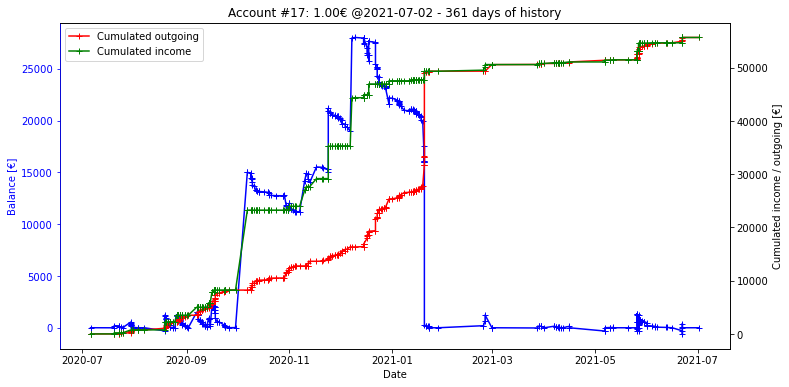

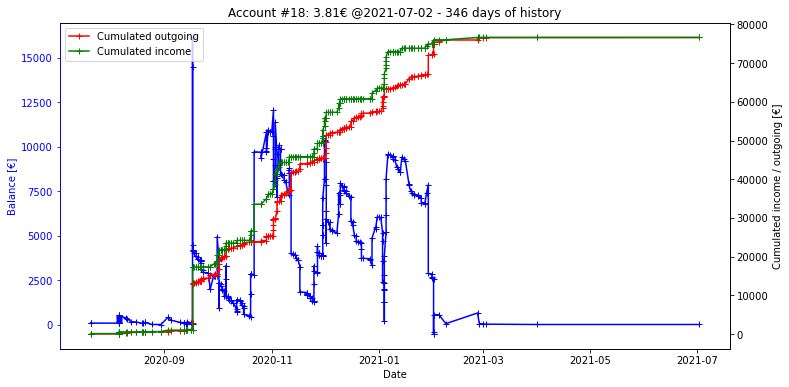

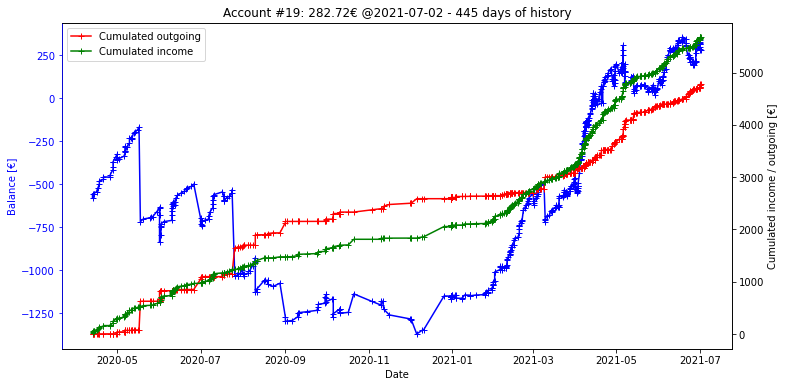

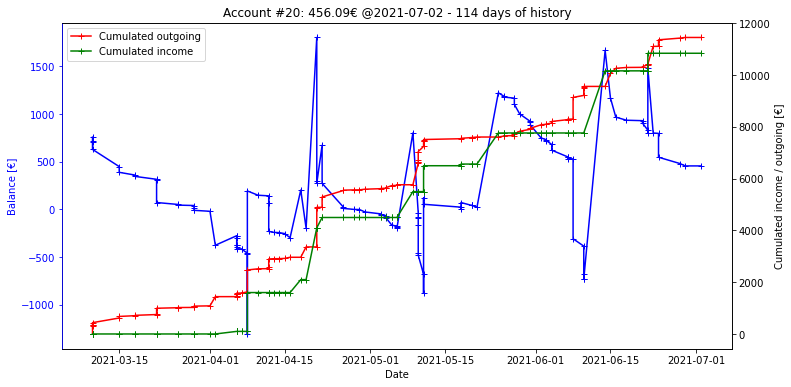

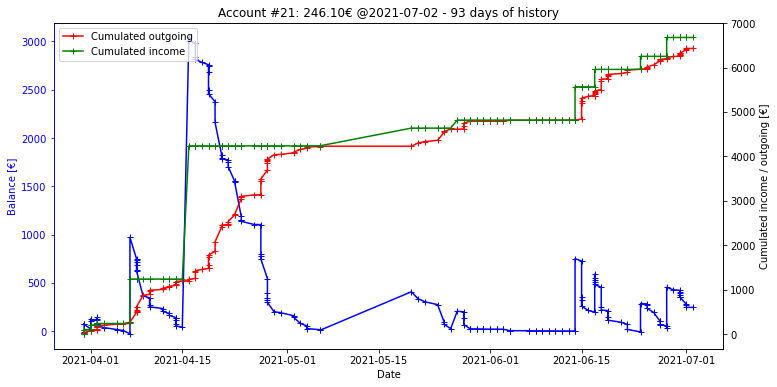

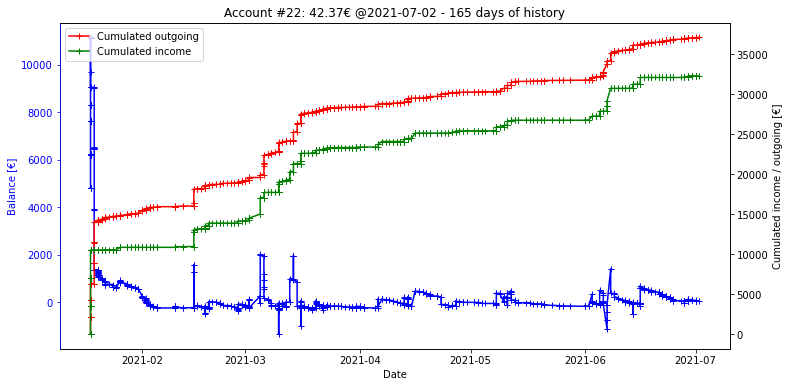

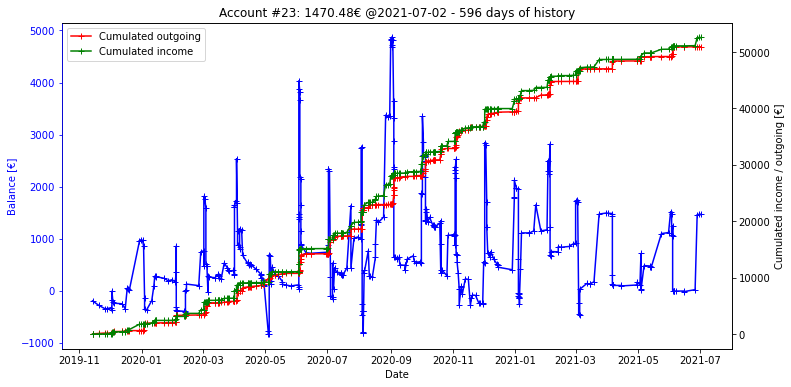

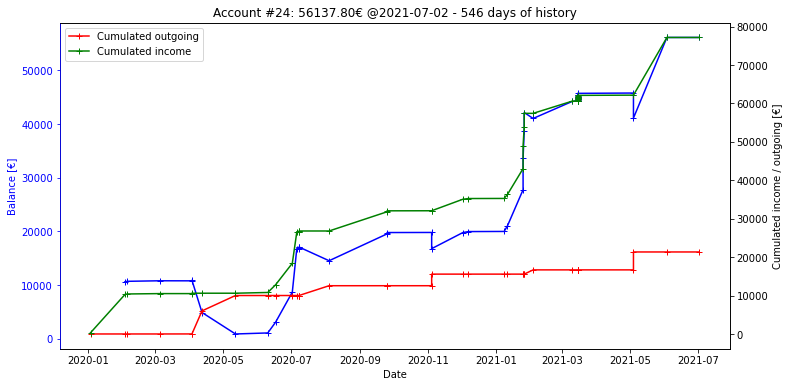

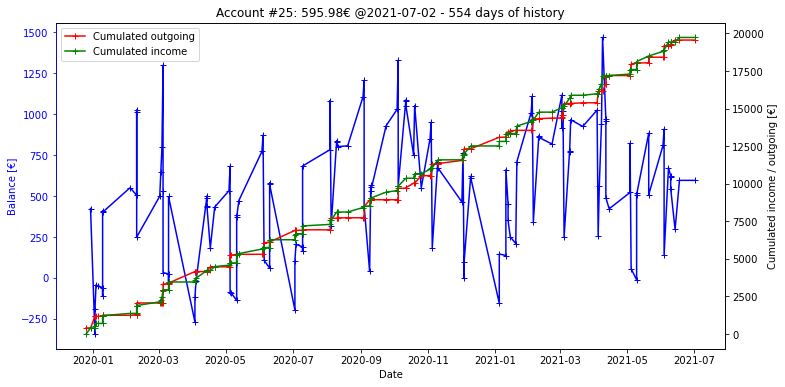

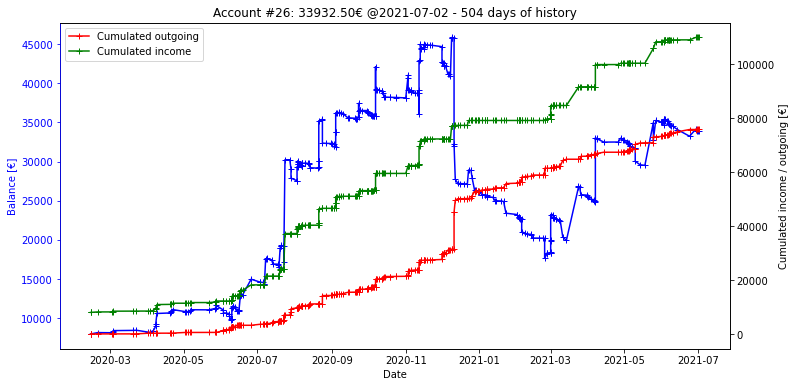

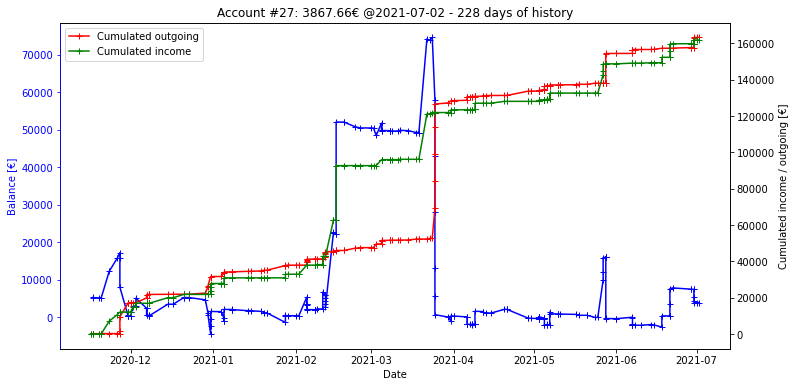

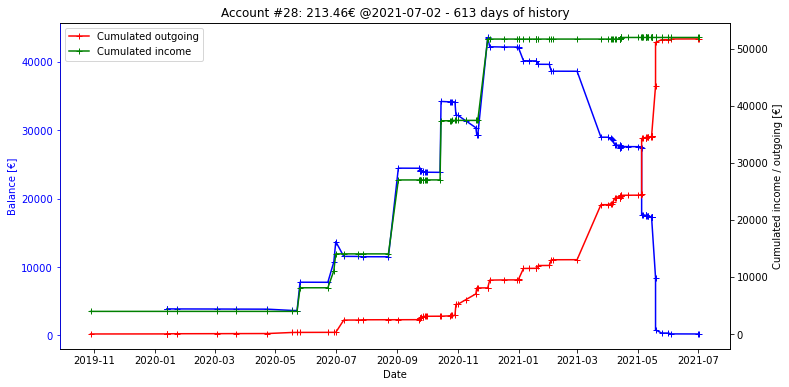

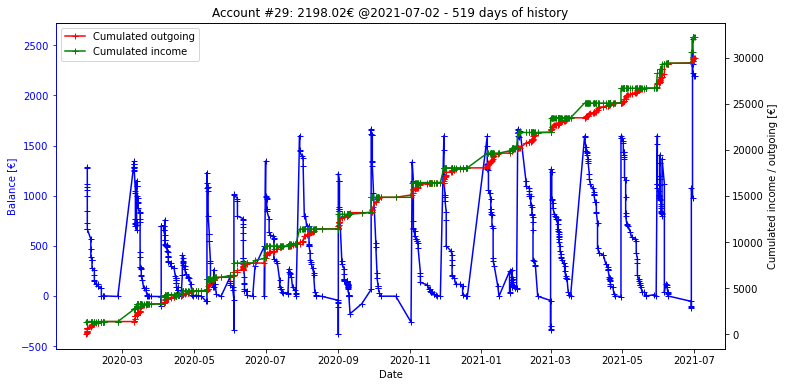

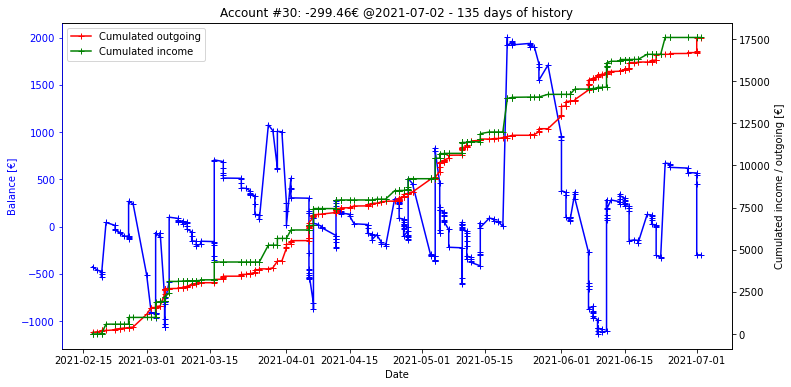

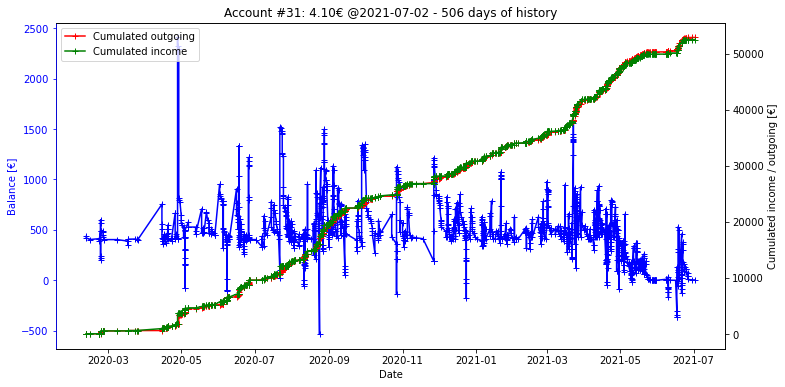

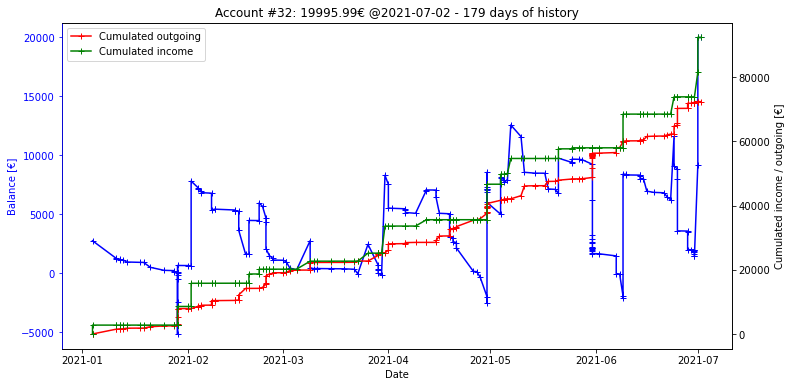

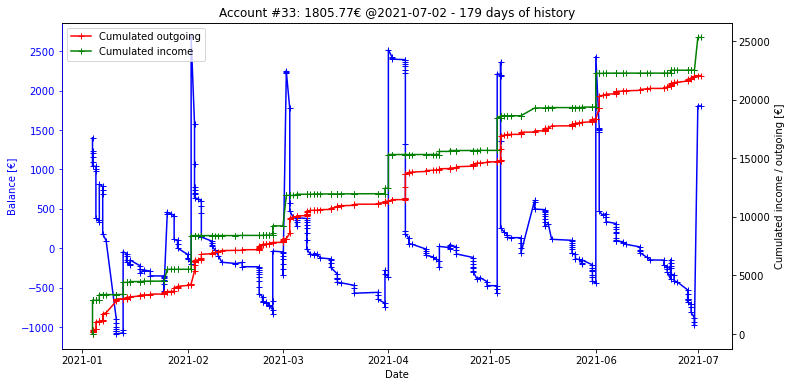

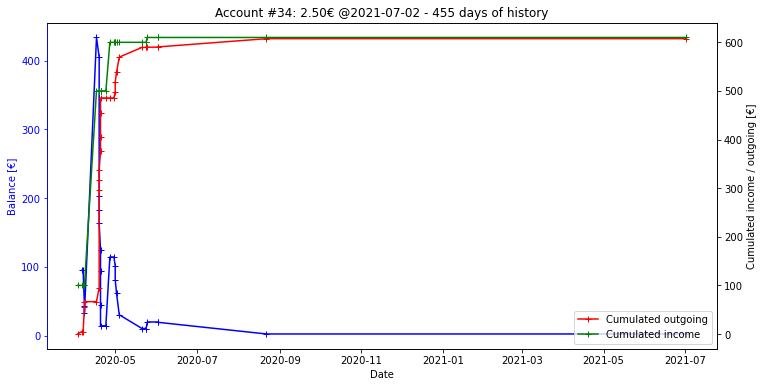

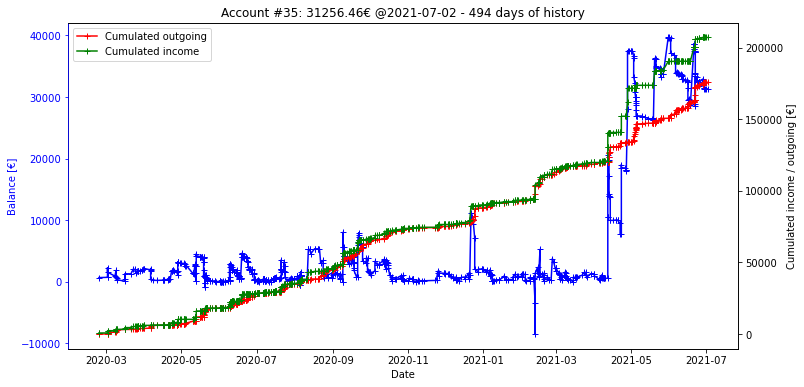

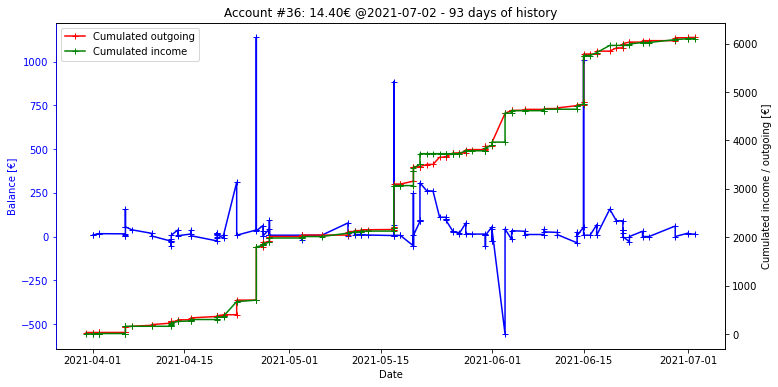

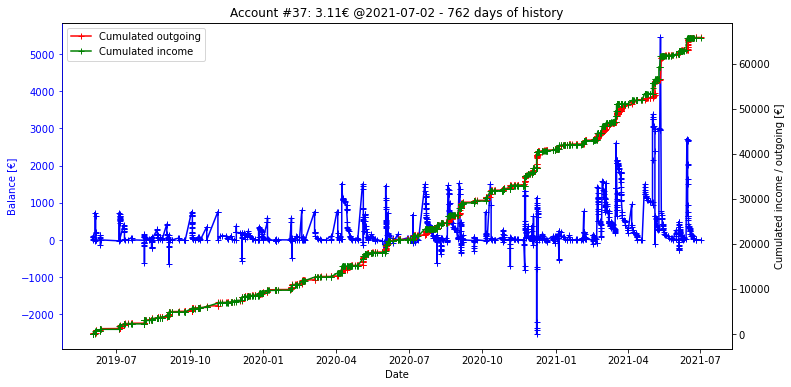

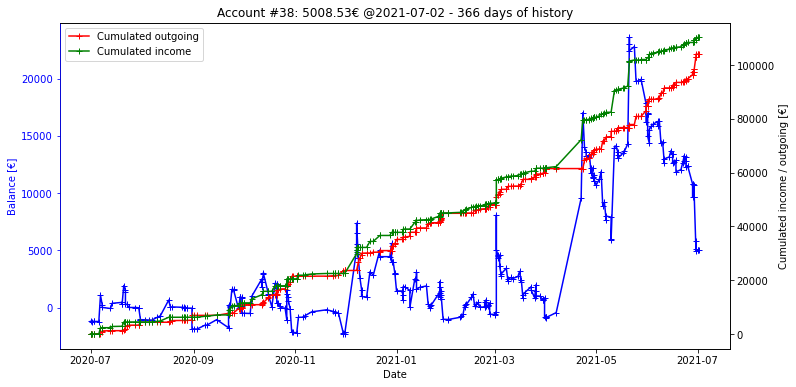

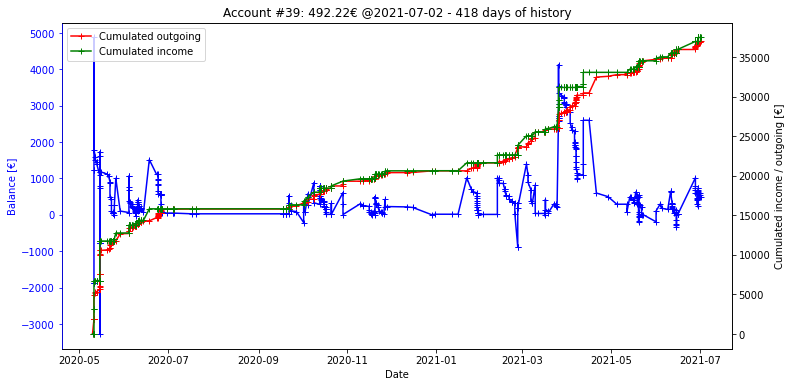

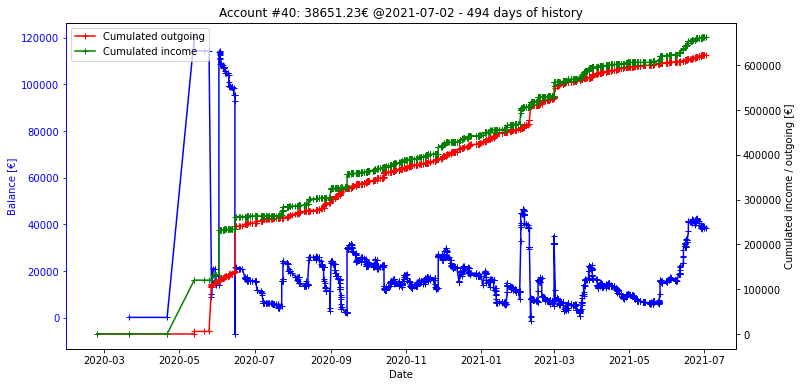

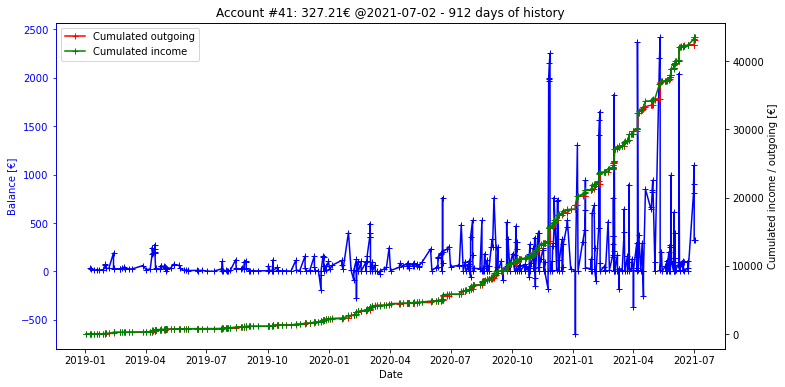

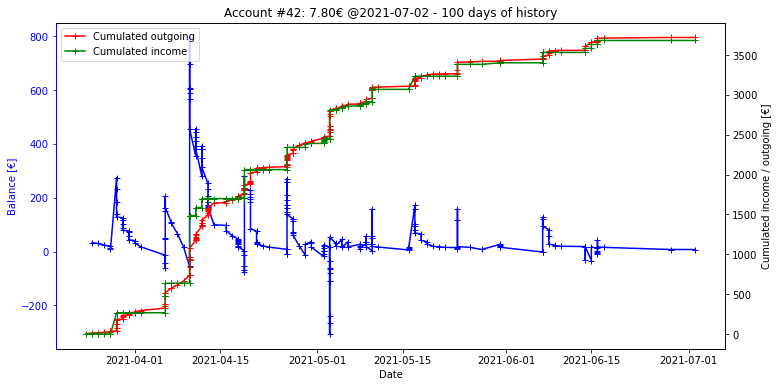

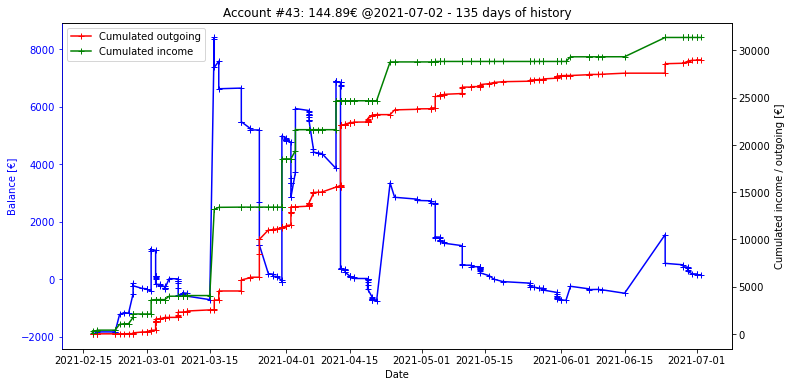

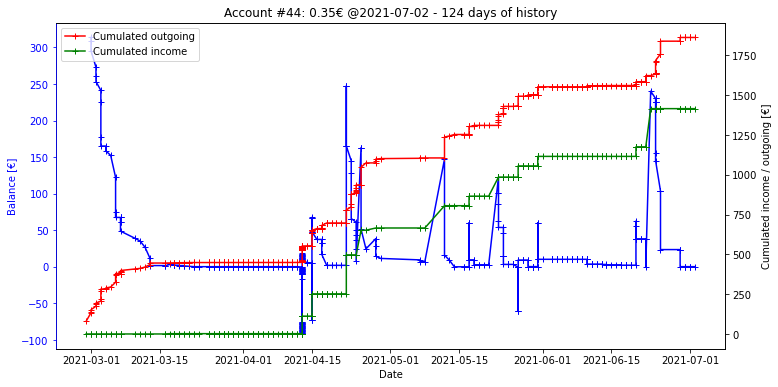

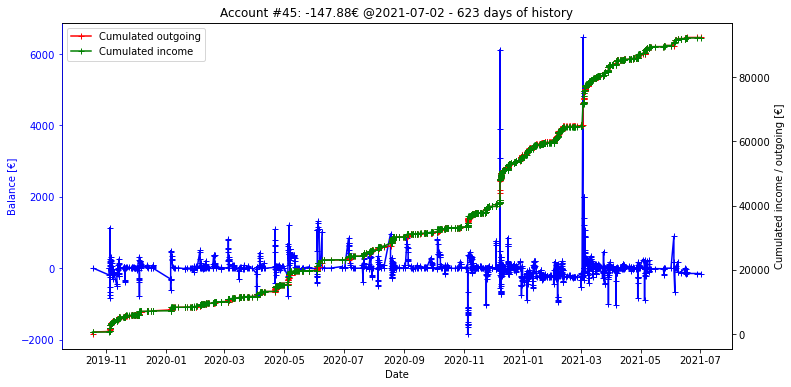

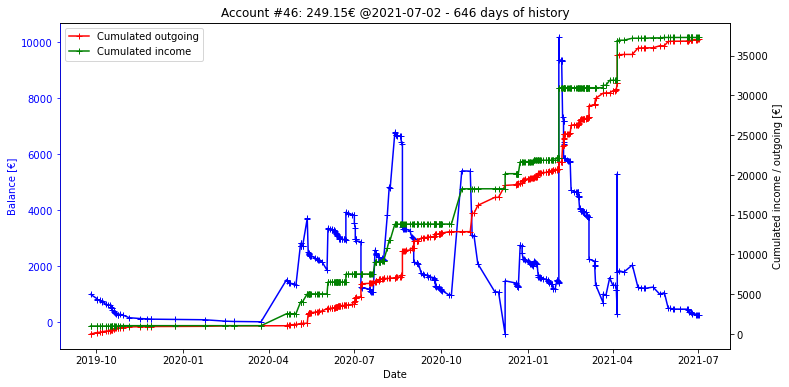

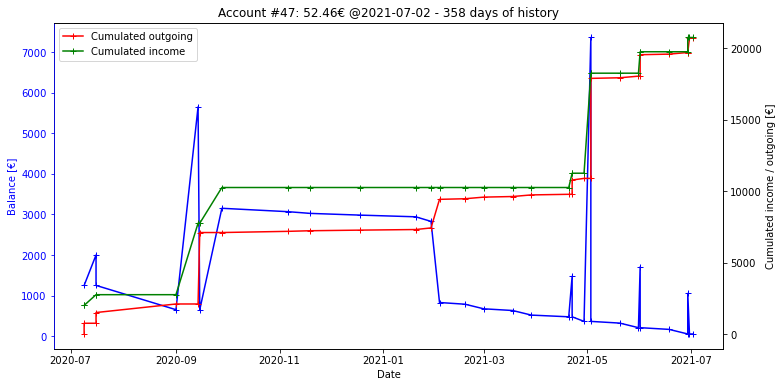

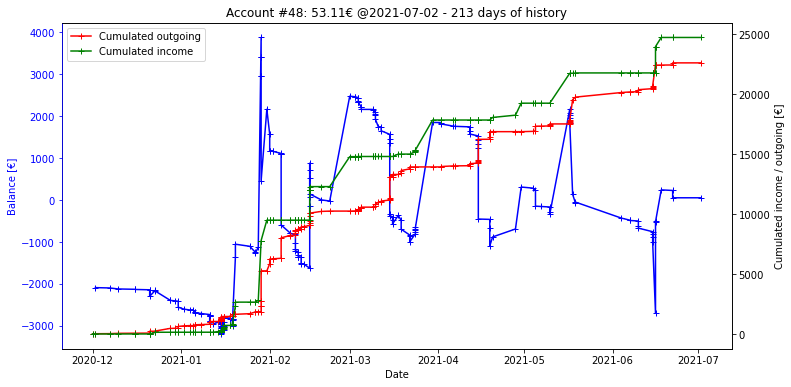

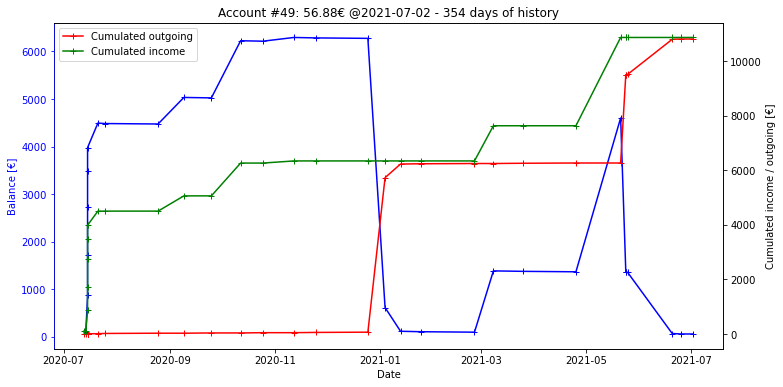

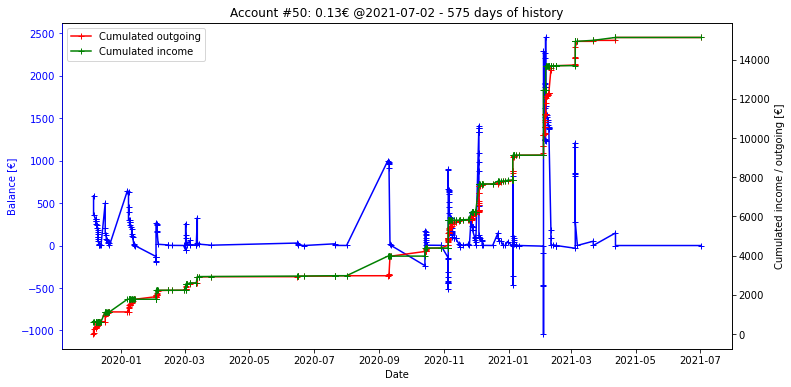

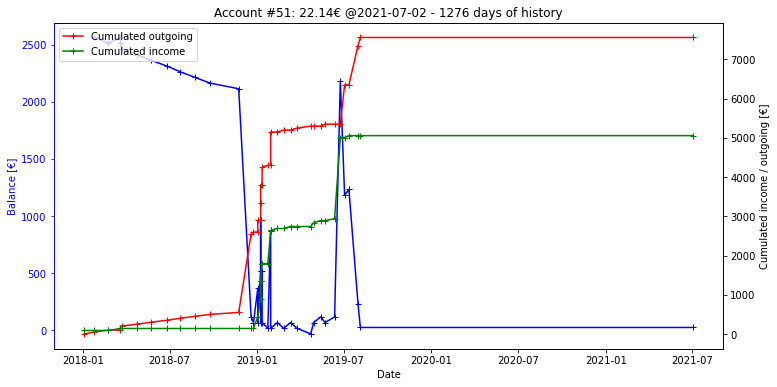

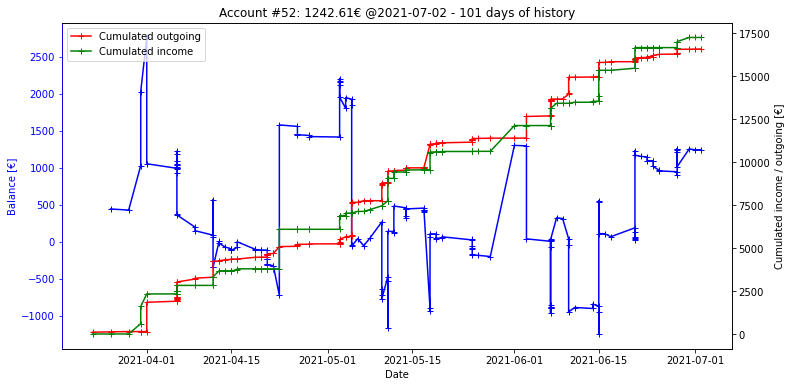

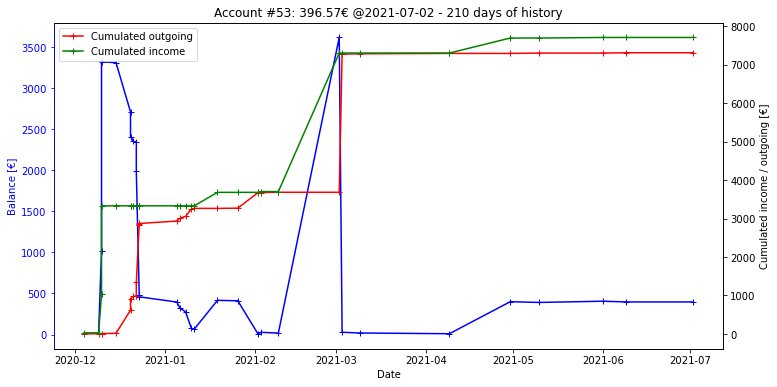

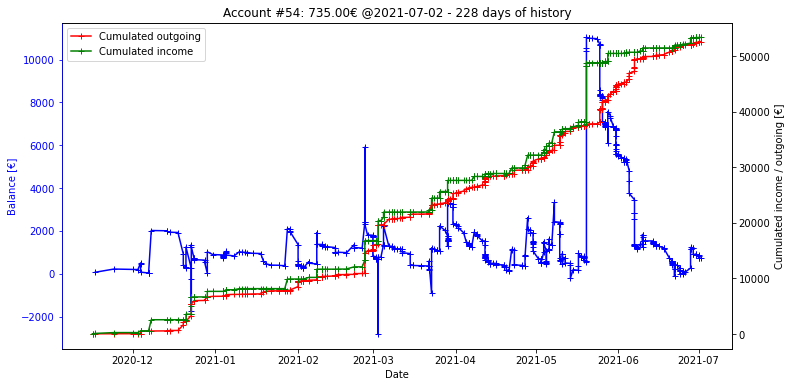

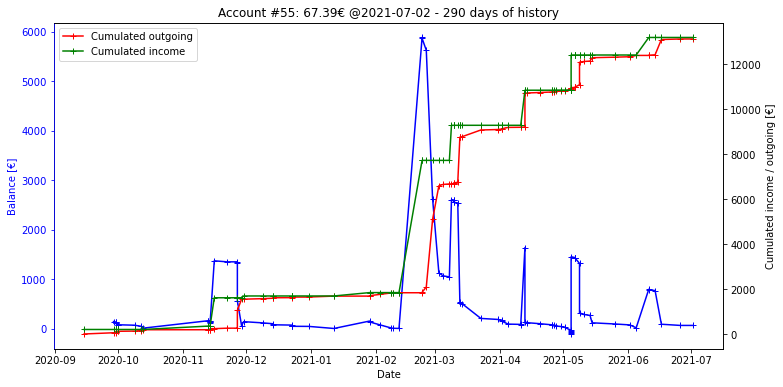

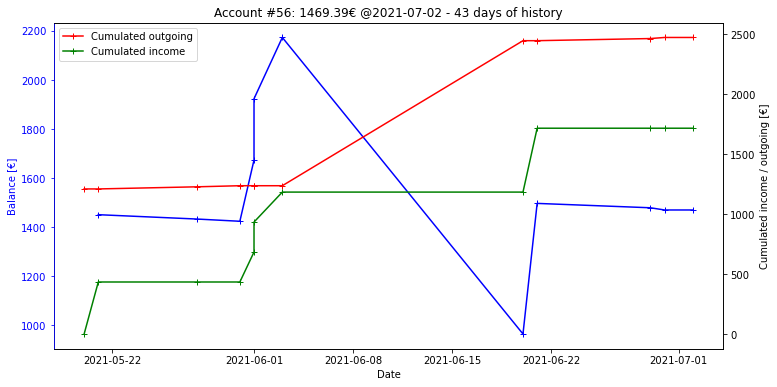

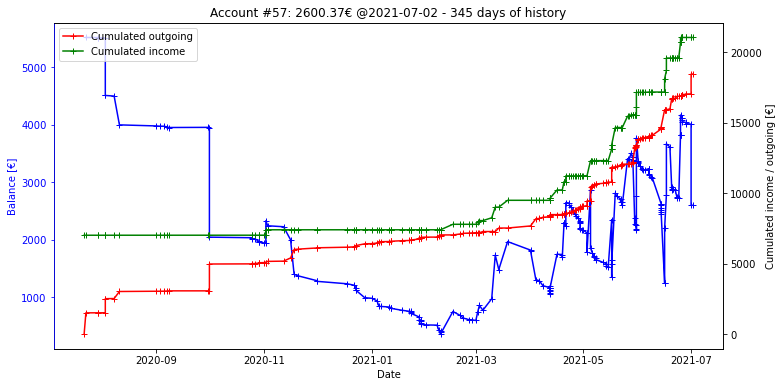

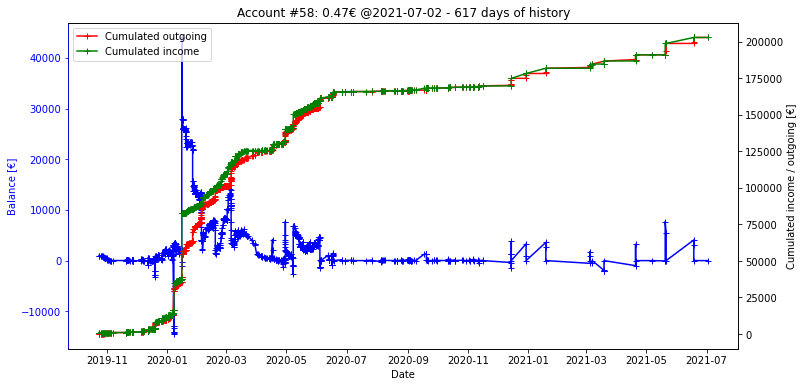

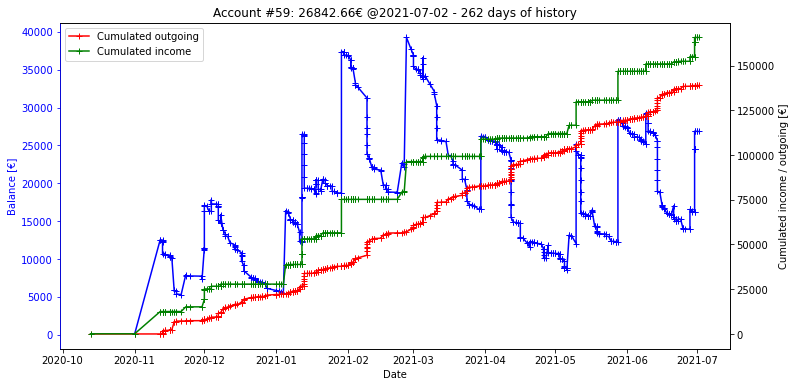

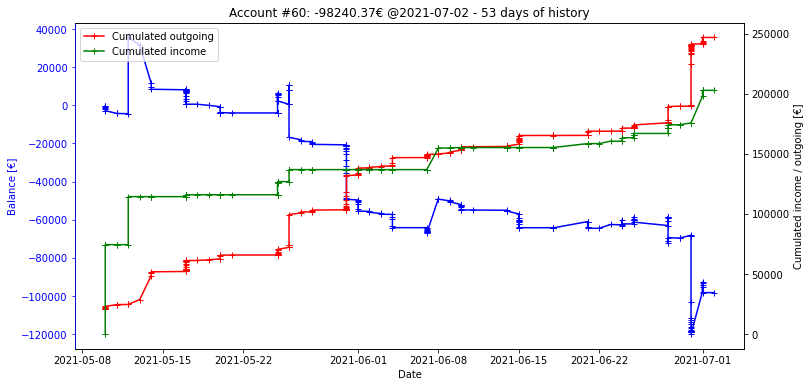

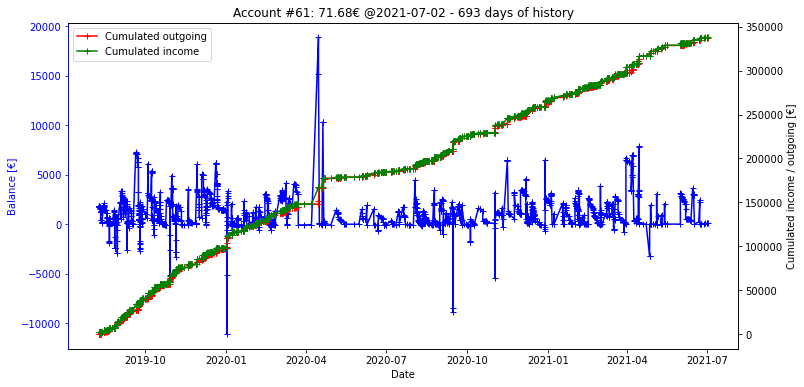

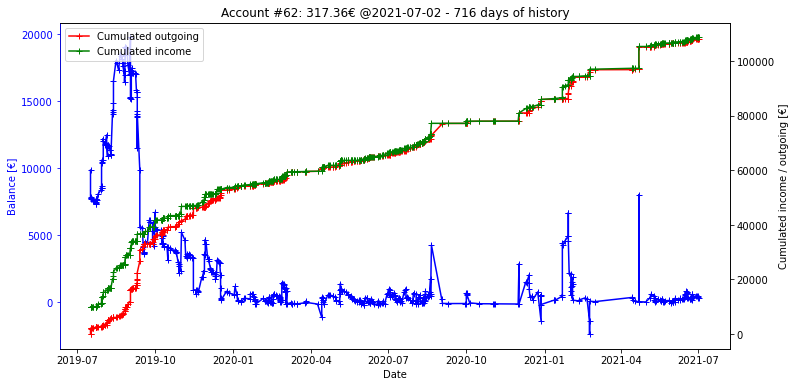

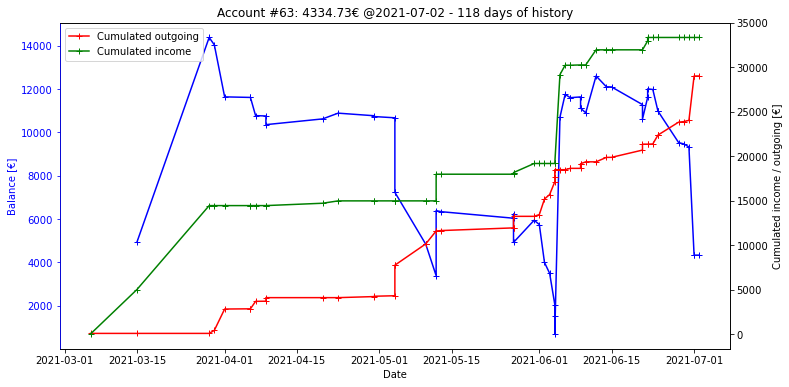

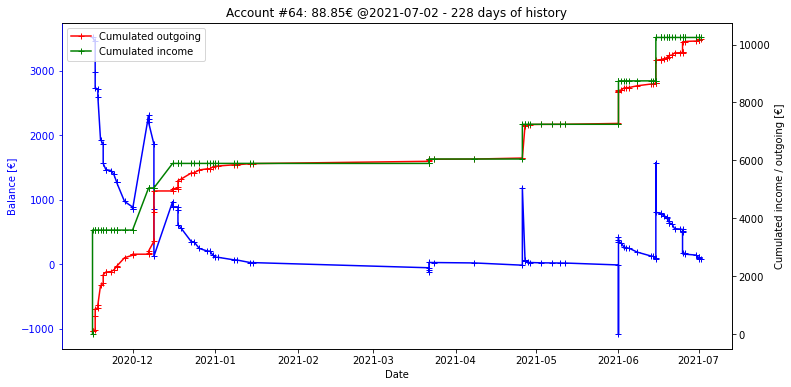

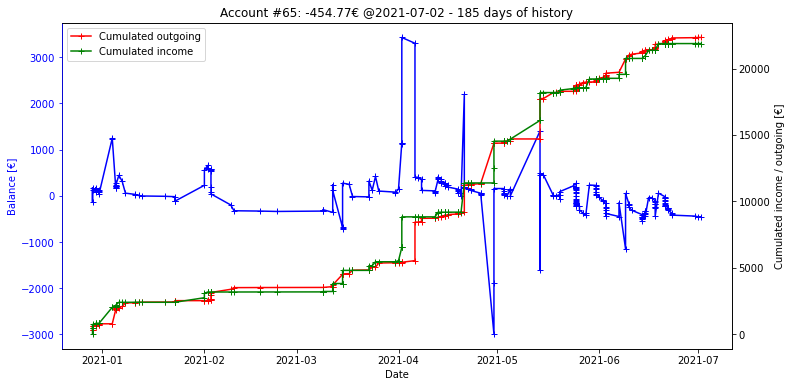

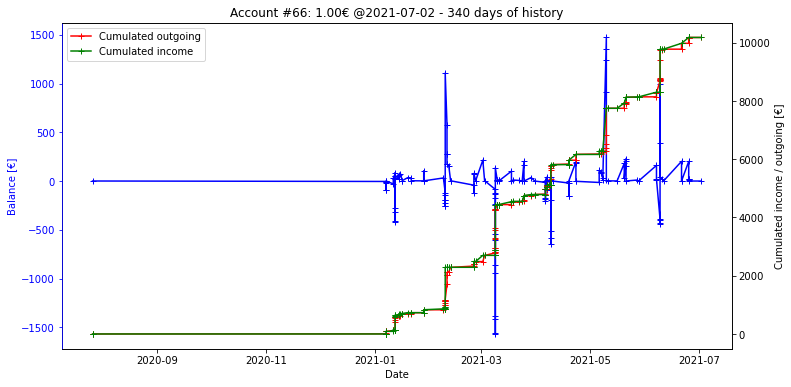

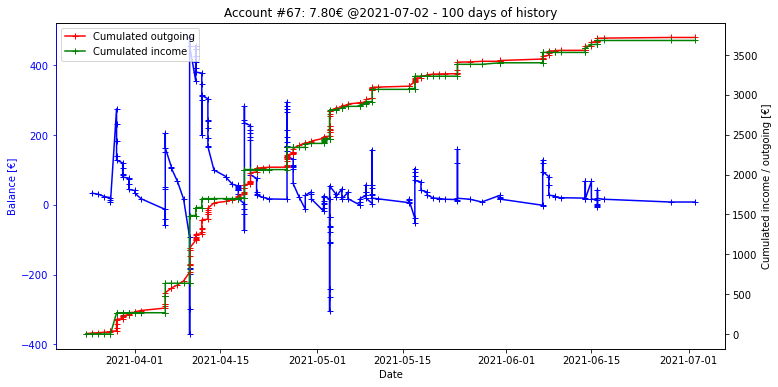

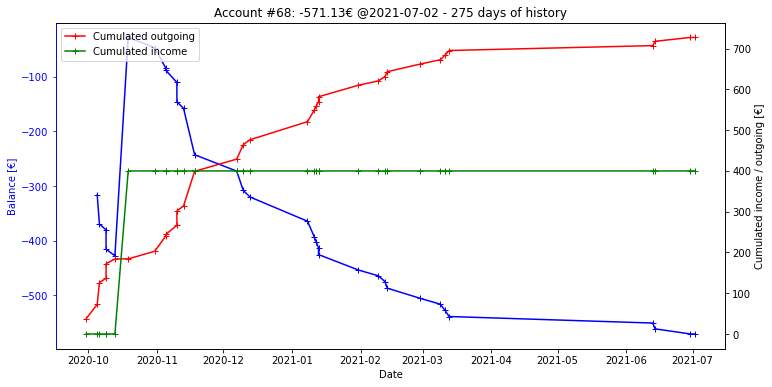

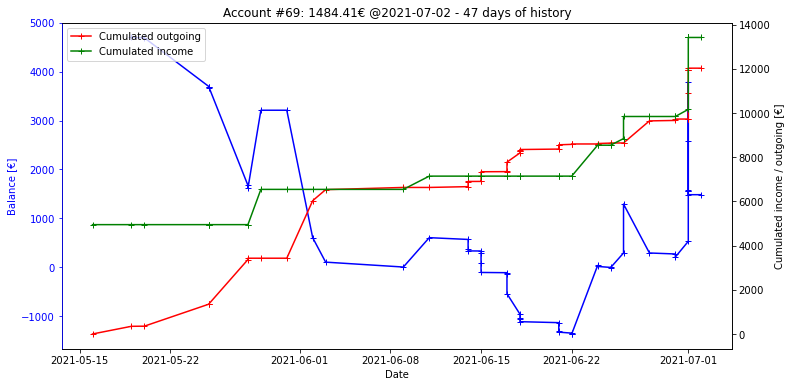

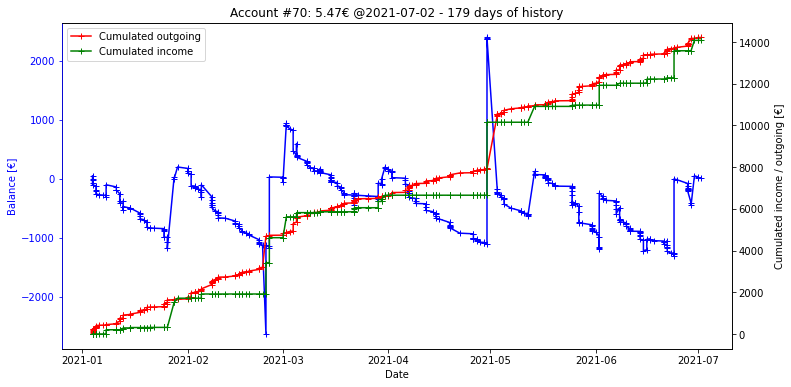

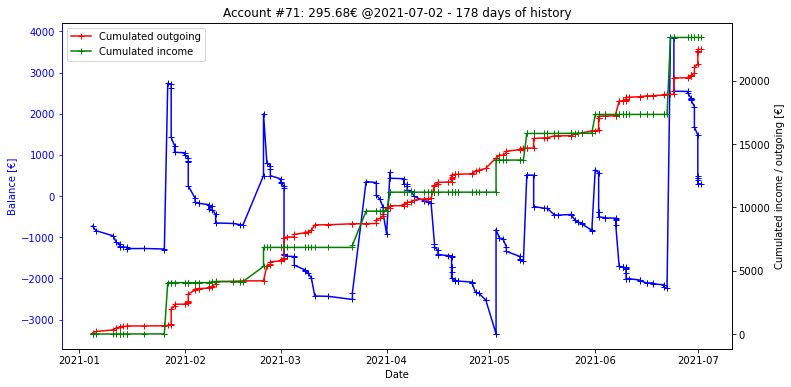

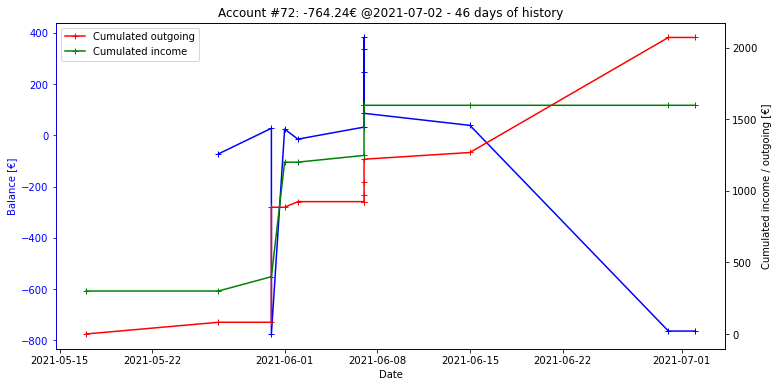

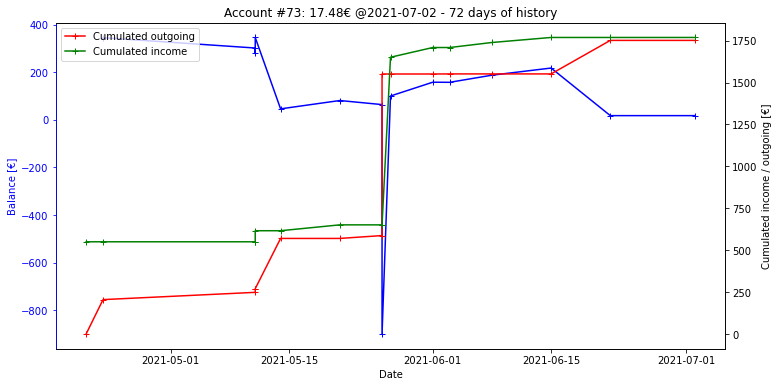

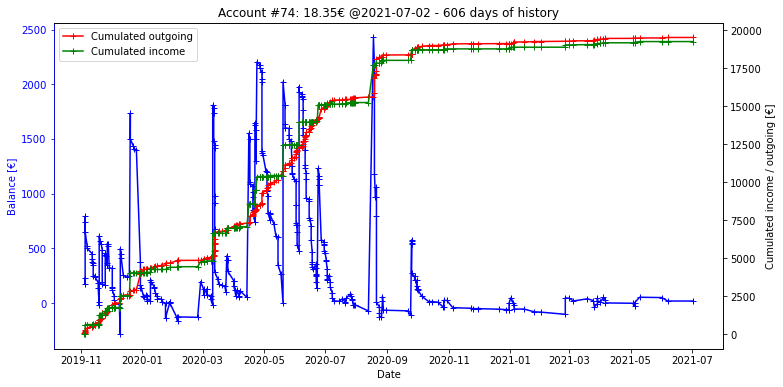

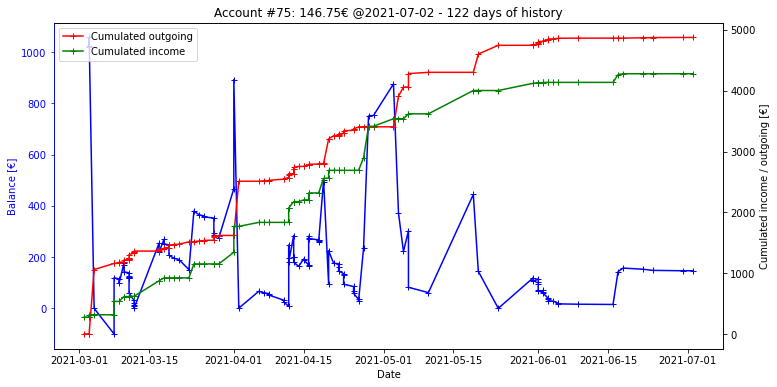

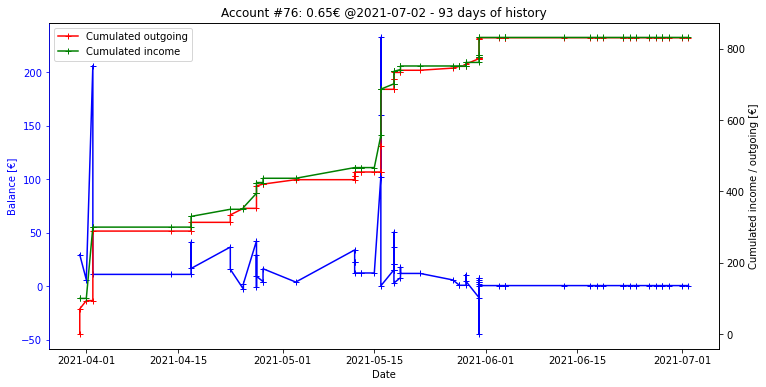

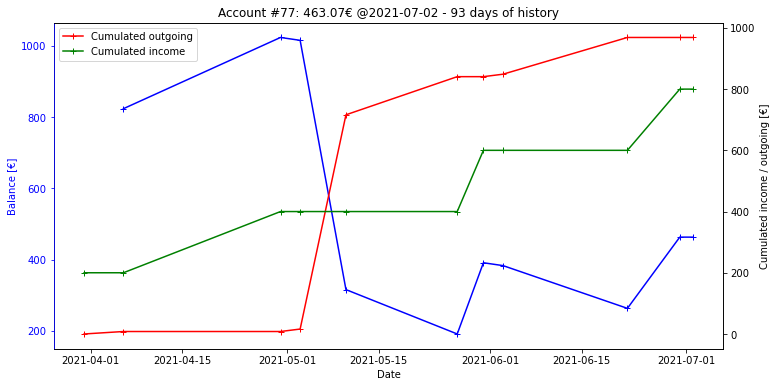

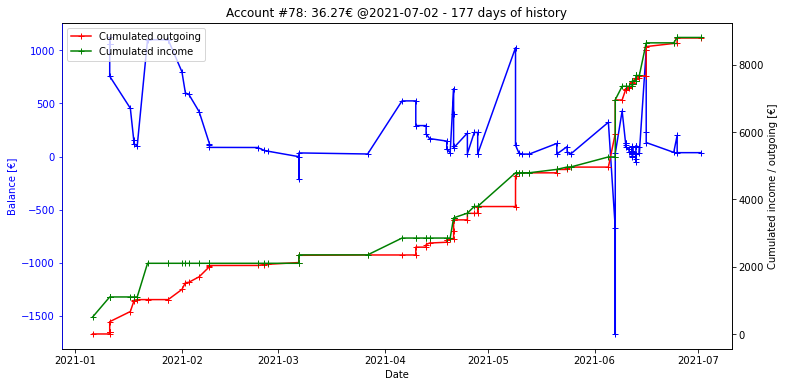

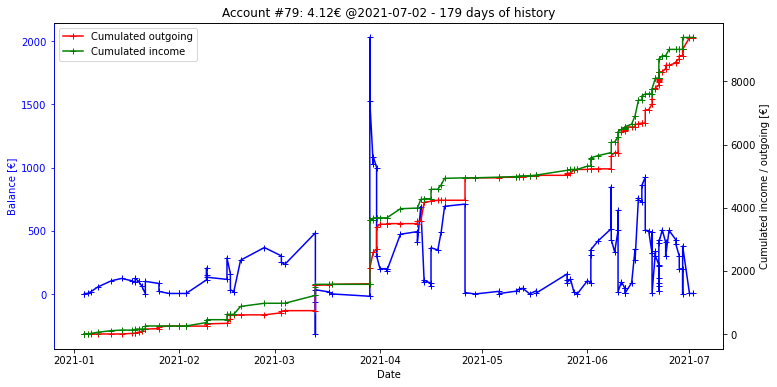

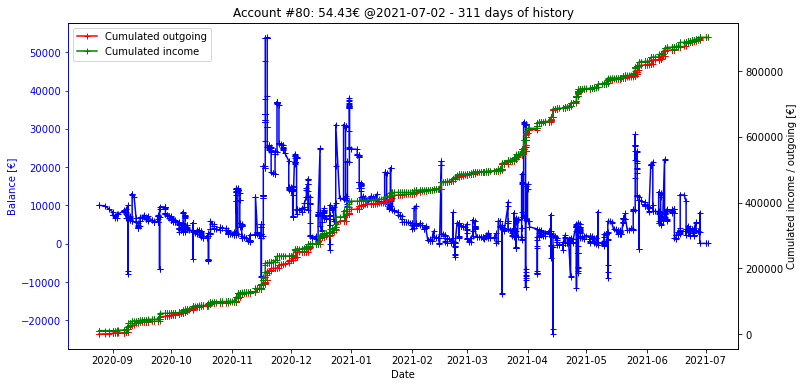

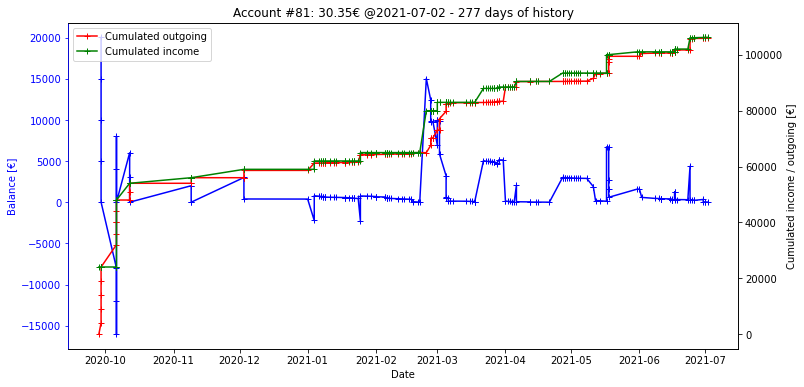

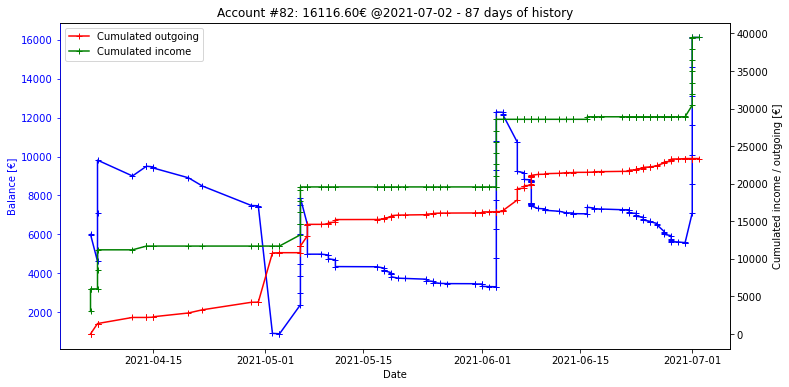

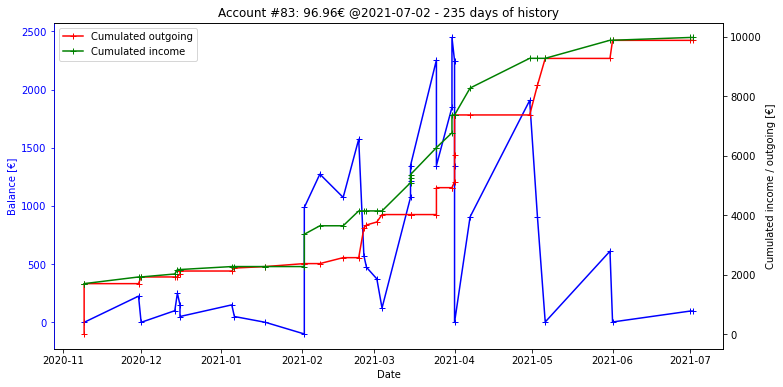

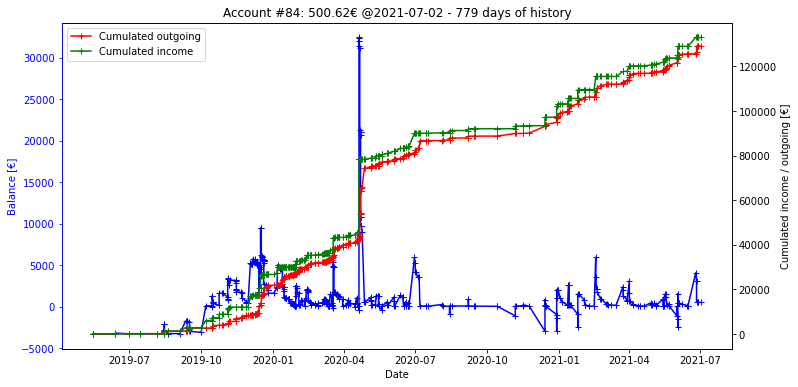

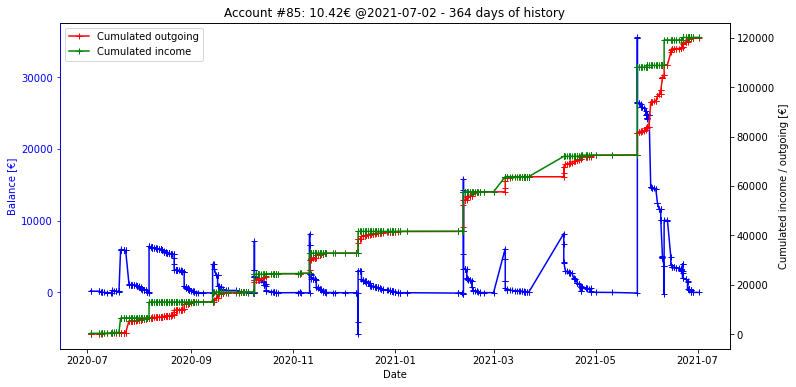

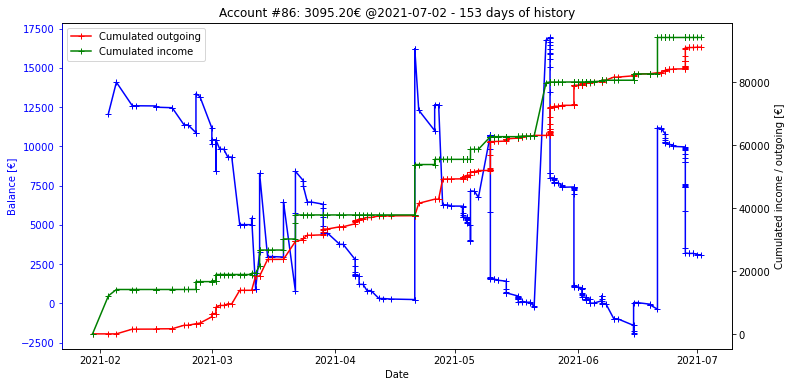

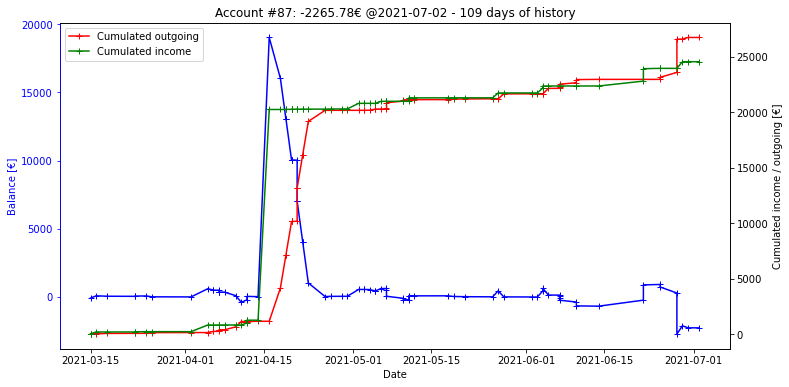

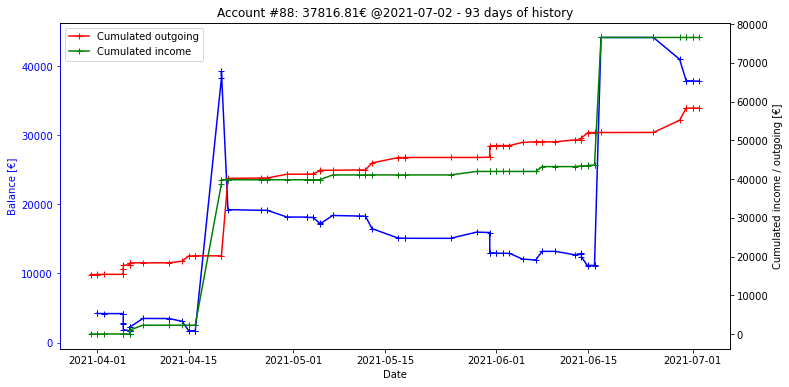

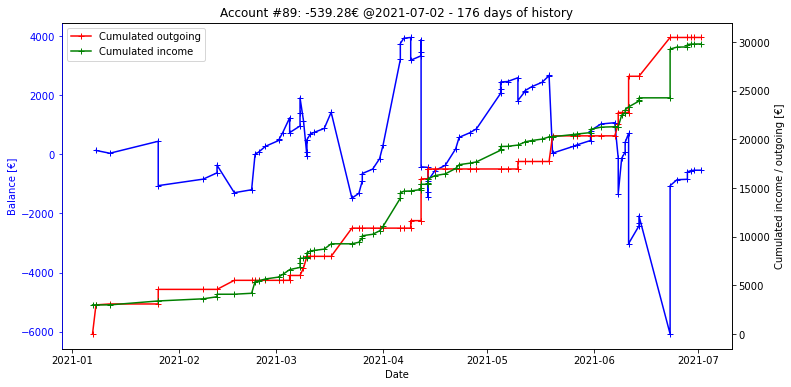

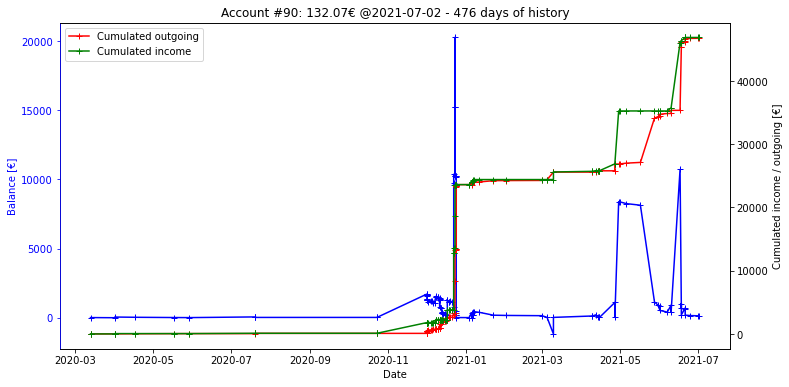

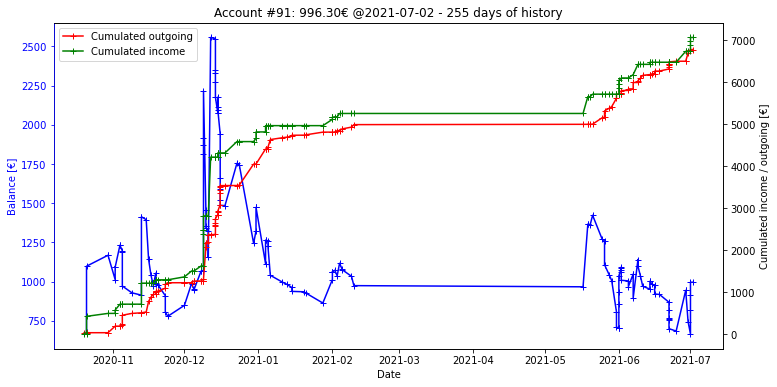

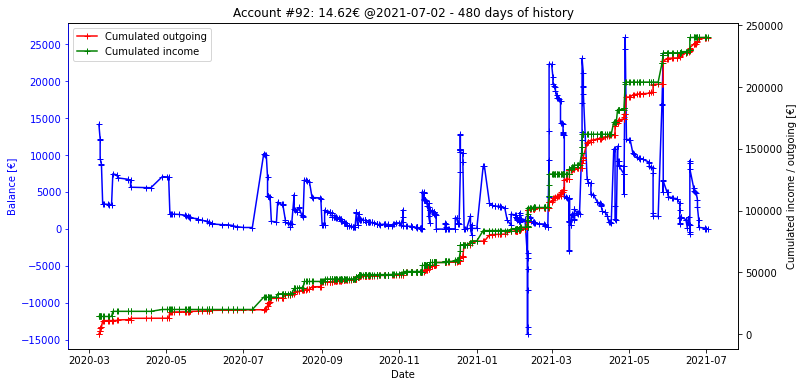

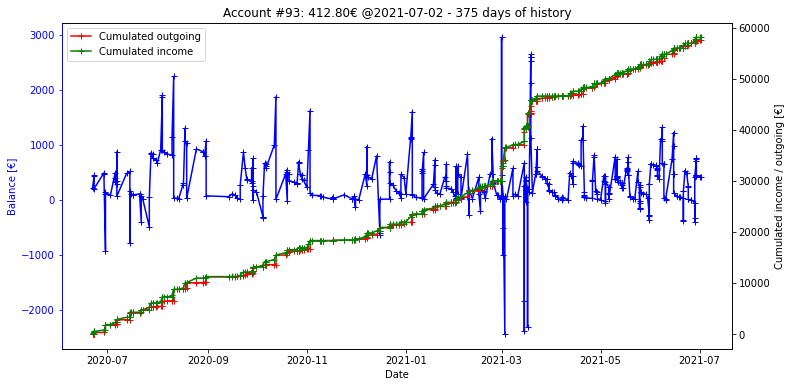

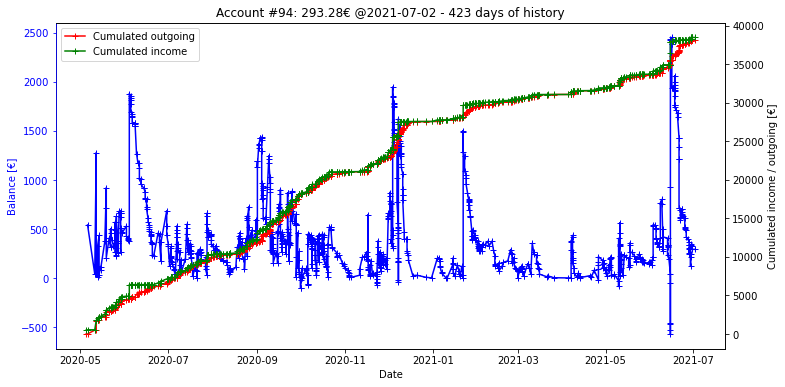

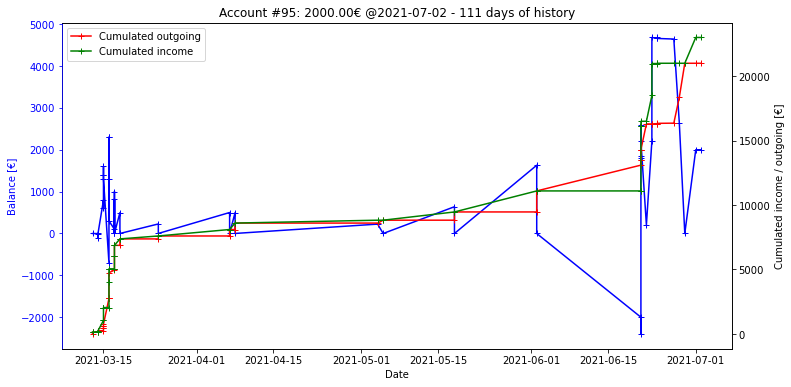

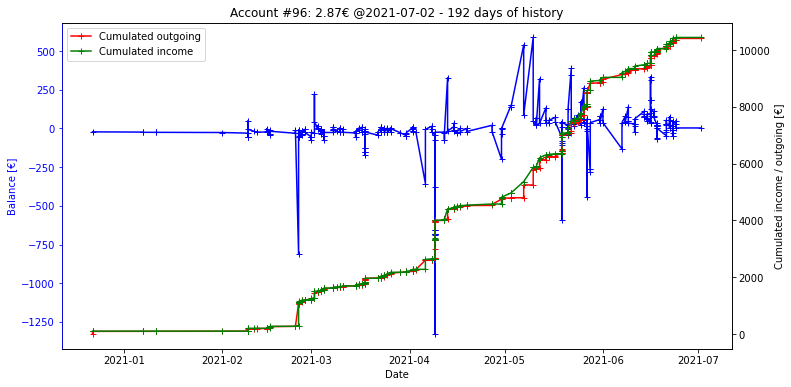

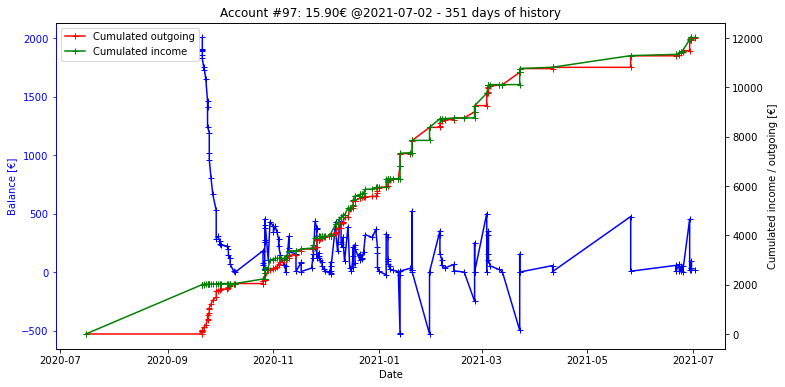

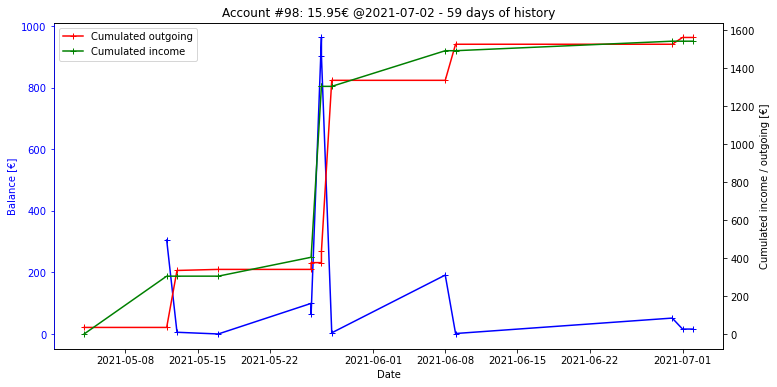

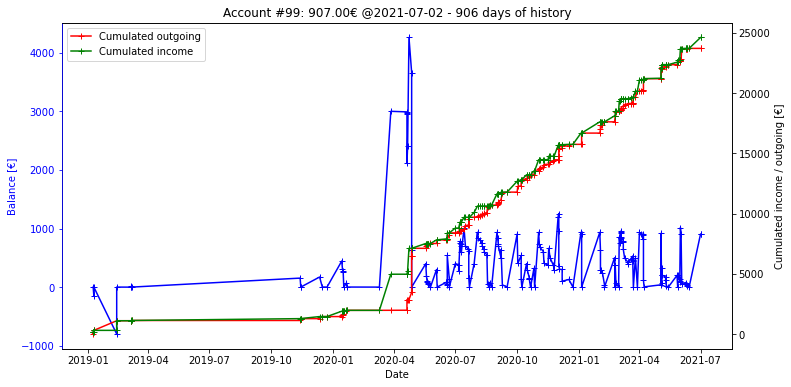

In [14]:
for my_id in range(100):
    account_history=account_info(transactions, accounts, my_id, debug_mode = True)

> These examples confirm that there is a **strong correlation between income & outgoing**. As a consequence, balance remains quite stable versus time, for most accounts.  
> A feature of the prediction model could be to use last 6 month income (and not only outgoing) to predict next month outgoing, assuming that balance should remain quite stable.  
> Moreover, **cumulated outgoing seems quite linear vs history: a prediction model based on linear regression should be efficient**

 
 ### Creating function ```get_last_6_month``` which:
 
 * Computes last 6 month data
   + Resampling data at last 6 month (1 month = 30 days)
   + Adding monthly income & outgoing
 * Creates a summary visualization

In [15]:
def get_last_6_month(account_history, debug_mode = False):
    '''
    Returns the condensed data of the last 6 months
    '''
    if ((account_history.date.max()-account_history.date.min())>np.timedelta64(6*30,'D')):
        last_6_month=account_history
        #Resampling every 30 days
        last_6_month=account_history.set_index("date").resample("30D",origin="end", label="right", closed="right")["income_cumsum","outgoing_cumsum","balance"].agg({"income_cumsum":"max","outgoing_cumsum":"max","balance":"mean"})
        last_6_month.interpolate(inplace=True) #Interpolation of missing values
        last_6_month=last_6_month.iloc[len(last_6_month)-7:]
        
        last_6_month["monthly_income"]=last_6_month.income_cumsum.diff()
        last_6_month["monthly_outgoing"]=last_6_month.outgoing_cumsum.diff()
        
        if debug_mode:
            plt.figure(figsize=(18,12))
            plt.subplot(221)
            plt.plot(account_history.date,account_history.balance,'b',label="Balance")
            plt.plot(last_6_month.index,last_6_month.balance,'c*-',linewidth=4,label="Balance (mean resample @last 6 month)")
            plt.legend()
            plt.ylabel("Balance [€]")
            plt.subplot(223)
            plt.plot(account_history.date,account_history.outgoing_cumsum,'r',label="Cumulated outgoing")
            plt.plot(last_6_month.index,last_6_month.outgoing_cumsum,'mo-',linewidth=4,label="Cumulated outgoing (resample @last 6 month)")
            plt.plot(account_history.date,account_history.income_cumsum,'g',label="Cumulated income")
            plt.plot(last_6_month.index,last_6_month.income_cumsum,'+-',color="lightgreen",linewidth=4,label="Cumulated income (resample @last 6 month)")
            plt.ylabel("[€]")
            plt.legend()
            plt.subplot(122)
            plt.plot(last_6_month.index,last_6_month.monthly_income,'o-',color="lightgreen",label="Monthly income")
            plt.plot(last_6_month.index,last_6_month.monthly_outgoing,'mo-',label="Monthly outgoing")
            plt.ylabel("[€]")
            plt.legend()
            
            plt.show()

    else:
        last_6_month=pd.DataFrame(columns={'date','income_cumsum','outgoing_cumsum','balance','monthly_income','monthly_outgoing'}).set_index('date')
    
    return last_6_month
    
    

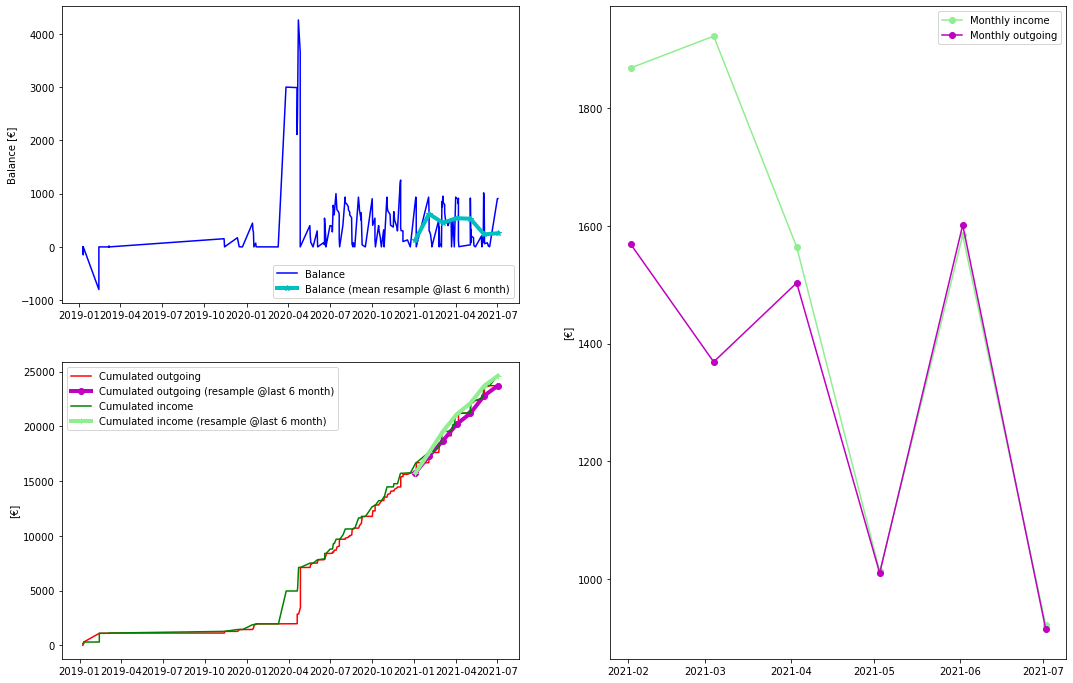

income_cumsum  outgoing_cumsum     balance  monthly_income  \
date                                                                     
2021-01-03       15747.47         15747.00  133.210000             NaN   
2021-02-02       17615.85         17316.00  617.828333         1868.38   
2021-03-04       19538.25         18685.00  452.620000         1922.40   
2021-04-03       21102.44         20188.20  540.251250         1564.19   
2021-05-03       22115.54         21198.40  528.237143         1013.10   
2021-06-02       23699.73         22799.96  235.601250         1584.19   
2021-07-02       24621.72         23714.96  257.095000          921.99   

            monthly_outgoing  
date                          
2021-01-03               NaN  
2021-02-02           1569.00  
2021-03-04           1369.00  
2021-04-03           1503.20  
2021-05-03           1010.20  
2021-06-02           1601.56  
2021-07-02            915.00

In [16]:
last_6_month=get_last_6_month(account_history,debug_mode=True)
last_6_month.head(7)

> Monthly outgoing & income on last 6 months will be used by the prediction model


 
 ### Complementary analysis: global trend ?
 
We've seen that a linear regression model should be efficient for outgoing prediction. This approach would be based only on considered account history.  
It could be interresting to see if there is, among all accounts, a global trend regarding monthly outgoing. This could reflect macro-economics behavior which could be taken into account in the prediction model.  
As an example, it seems quite logical that family bank accounts are subject to higher expenses for end of year celebrations.
  


Grouping transactions by year & month:

In [17]:
stat_by_year_and_month=transactions[transactions.amount<0]["amount"].groupby([transactions.date.dt.year,transactions.date.dt.month]).describe()

In [18]:
stat_by_year_and_month

count        mean          std        min       25%     50%  \
date date                                                                  
2018 1       104.0 -168.879038   370.349729   -2200.00 -125.8875 -49.400   
     2        85.0 -140.175294   204.337783   -1454.67 -182.2100 -69.960   
     3       112.0 -151.588750   334.360611   -2000.00 -100.0000 -50.000   
     4       100.0 -126.622500   244.215346   -1454.67 -138.6175 -44.445   
     5       104.0 -129.178654   303.711670   -2306.00 -108.1750 -38.190   
     6       170.0 -149.812176   379.665055   -3193.00  -87.3700 -36.080   
     7       214.0 -123.229065   284.345467   -2042.50  -85.4125 -29.650   
     8       235.0  -94.521872   242.274890   -1863.00  -65.0700 -30.760   
     9       215.0  -98.799023   331.085467   -3894.38  -64.7650 -22.100   
     10      406.0 -124.524236   358.335061   -5000.00  -68.1650 -22.745   
     11      313.0 -127.040639   316.406124   -3060.74  -91.6400 -39.950   
     12      309.0 -103.712233   278.113600   -2640.82  -65.6500 -27.540   
2019 1      1112.0 -174.426853  1110.698155  -30000.00  -74.0925 -27.000   
     2      1072.0 -118.478330   370.932827   -5000.00  -60.0900 -20.000   
     3      1219.0 -163.168220   864.259736  -21682.92  -77.5000 -20.000   
     4      1535.0 -110.276801   488.322079  -13647.68  -54.2250 -17.700   
     5      1544.0 -136.958938   797.512183  -20006.36  -51.6600 -19.070   
     6      2230.0 -141.528184  1436.674724  -63000.00  -55.0000 -20.000   
     7      3153.0 -108.541494   499.977355  -21458.72  -64.9800 -20.000   
     8      3422.0 -135.167469  1084.367739  -40000.00  -60.0000 -20.000   
     9      4127.0 -142.067778   503.181016  -11761.92  -75.0700 -20.000   
     10     5733.0 -189.411887  4669.569486 -351200.00  -60.5500 -20.000   
     11     6399.0 -130.608331   609.295489  -30127.32  -66.2050 -20.000   
     12     7154.0 -127.835085   529.110674  -19971.12  -66.6675 -20.110   
2020 1      8009.0 -136.313221   583.440165  -16069.20  -60.5500 -20.000   
     2      8506.0 -129.055272   598.222980  -20000.00  -56.5000 -19.500   
     3      7660.0 -147.797548   639.628243  -30000.00  -73.6200 -21.080   
     4      6779.0 -181.537416  1285.703286  -82201.68  -81.6500 -25.000   
     5     10259.0 -157.527568  1302.196005 -100000.00  -76.7450 -23.500   
     6     14199.0 -145.724668  1082.393986 -100000.00  -71.4900 -22.750   
     7     16392.0 -151.760126   841.159182  -52000.00  -70.0000 -22.500   
     8     17261.0 -165.646898   860.732857  -40000.00  -72.0000 -23.980   
     9     19828.0 -166.194863   819.179031  -34400.00  -74.0900 -22.975   
     10    21688.0 -182.912631   953.854294  -85557.00  -80.0000 -24.990   
     11    20368.0 -188.932139   848.569935  -41977.89  -87.8975 -26.090   
     12    27594.0 -213.504780  1595.386682 -186299.46 -100.0000 -30.000   
2021 1     26561.0 -214.173143  1408.170559  -85536.00  -93.6500 -27.300   
     2     25353.0 -201.034300   899.903296  -72145.98  -95.7200 -28.100   
     3     32228.0 -205.079085   856.987675  -32000.00  -96.0000 -27.000   
     4     32140.0 -202.826720   932.209889  -72100.00  -91.6475 -27.725   
     5     34887.0 -206.376649  1571.735778 -219805.03  -88.5000 -27.030   
     6     38620.0 -204.145328  1210.056046 -141235.00  -90.0000 -26.500   
     7      1544.0 -222.619773   697.777642   -9060.00 -100.0000 -29.450   

               75%   max  
date date                 
2018 1    -21.0050 -2.50  
     2    -28.1000 -2.00  
     3    -28.8250 -0.47  
     4    -16.0000 -1.00  
     5     -9.3750 -0.98  
     6    -11.4375 -0.50  
     7     -6.8500 -0.50  
     8    -12.5550 -0.44  
     9     -9.8950 -0.20  
     10    -9.5925 -0.43  
     11   -11.8000 -0.50  
     12   -10.0000 -0.50  
2019 1     -9.9900 -0.01  
     2     -8.0000 -0.03  
     3     -7.6000 -0.01  
     4     -6.9600 -0.06  
     5     -7.0375 -0.01  
     6     -7.0000 -0.19  
     7     -7.5000 -0.01  
     8     -7.9600 -0.20 

Visualization

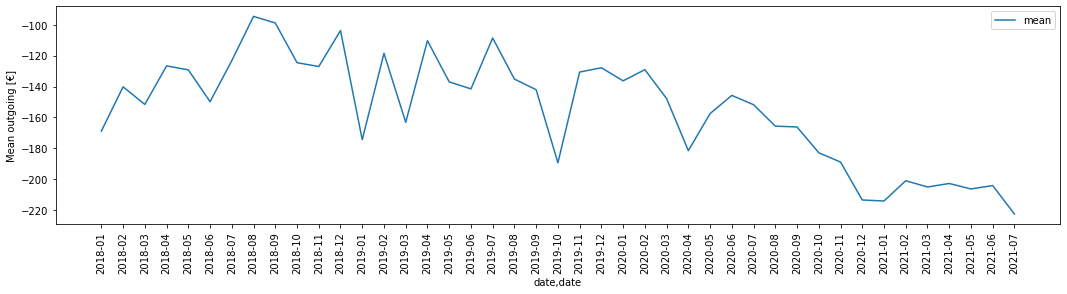

In [19]:
plt.figure(figsize=(18,4))
ax=plt.subplot()
stat_by_year_and_month.plot(y="mean",ax=ax)
ax.set_xticks(range(len(stat_by_year_and_month)));
ax.set_xticklabels(["%s-%02d" % item for item in stat_by_year_and_month.index.tolist()], rotation=90);
plt.ylabel("Mean outgoing [€]")
plt.show()

> There is no specific monthly trend => we can't use it in the prediction model

***

## Creation of class ```Account_synthesis``` to facilitate work

In [20]:
import Account_synthesis as Acc

 
### Example
 
 * Creation of an account synthesis, based on account balance at update date, and transactions history

In [21]:
my_account=pd.DataFrame(data={'update_date':[np.datetime64('today','D')],'balance':[500]})
my_transactions=pd.DataFrame(data={'date':[np.datetime64('today','D')-np.timedelta64(i,'W') for i in range(52)],'amount':1000*(2*np.random.rand(52)-1)})

my_account_synthesis=Acc.Account_synthesis(my_account,my_transactions)

 * Available properties & methods

In [22]:
print(dir(my_account_synthesis))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'analysis_date', 'get_last_6_month', 'history', 'history_length', 'history_length_at_analysis_date', 'last_6_month', 'monthly_outgoing_to_predict', 'next_monthly_outgoing', 'plot_history', 'plot_last_6_month', 'predict_next_monthly_outgoing', 'update_balance', 'update_date']


 * Print account status

In [23]:
print(my_account_synthesis)

Account synthesis:
  @ Update date (2021-11-20): 500.00€ - 357 days of history
  @ Analysis date (2021-11-20): 357 days of history


 * Plot history

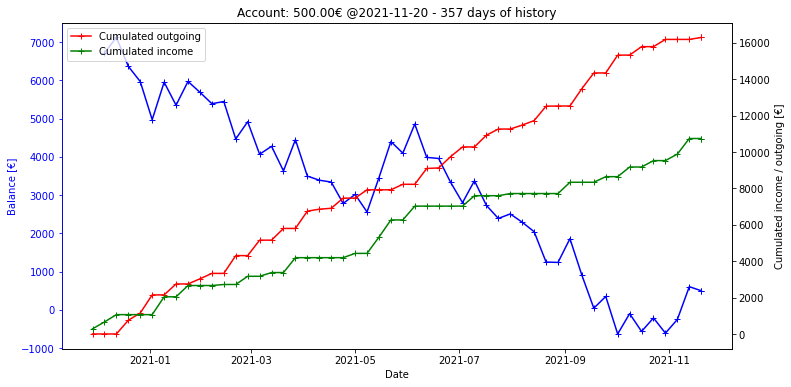

In [24]:
my_account_synthesis.plot_history()

 * Plot last 6 month data

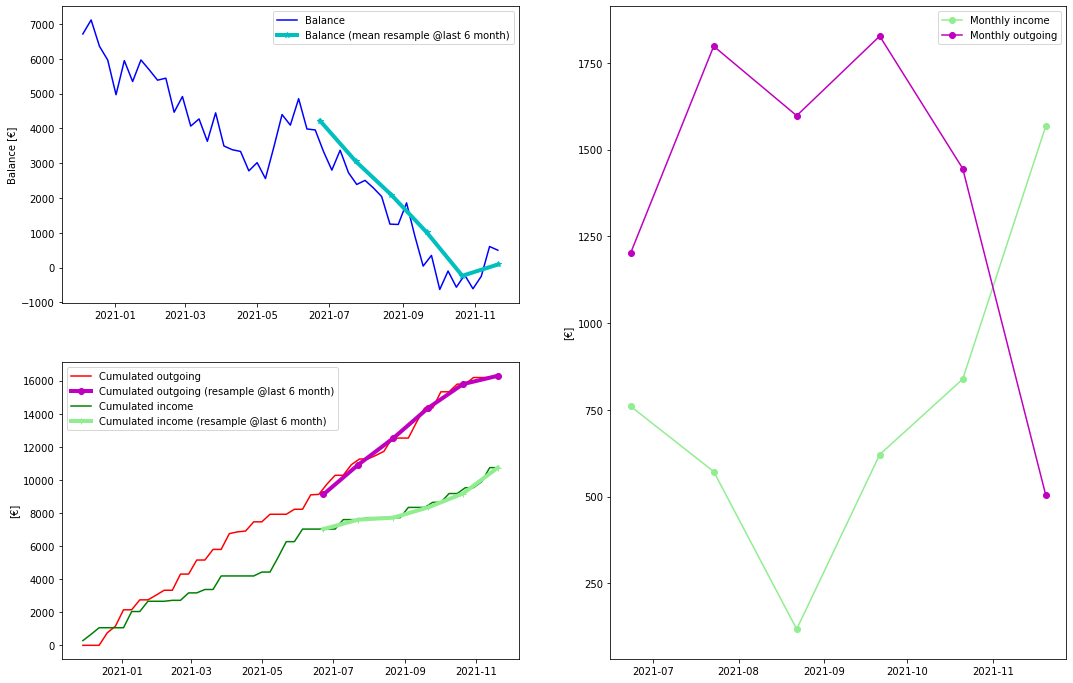

In [25]:
my_account_synthesis.plot_last_6_month()

 * Change analysis date from which perform last 6 month data (useful from testing prediction model) 


Account synthesis:
  @ Update date (2021-11-20): 500.00€ - 357 days of history
  @ Analysis date (2021-07-15): 229 days of history


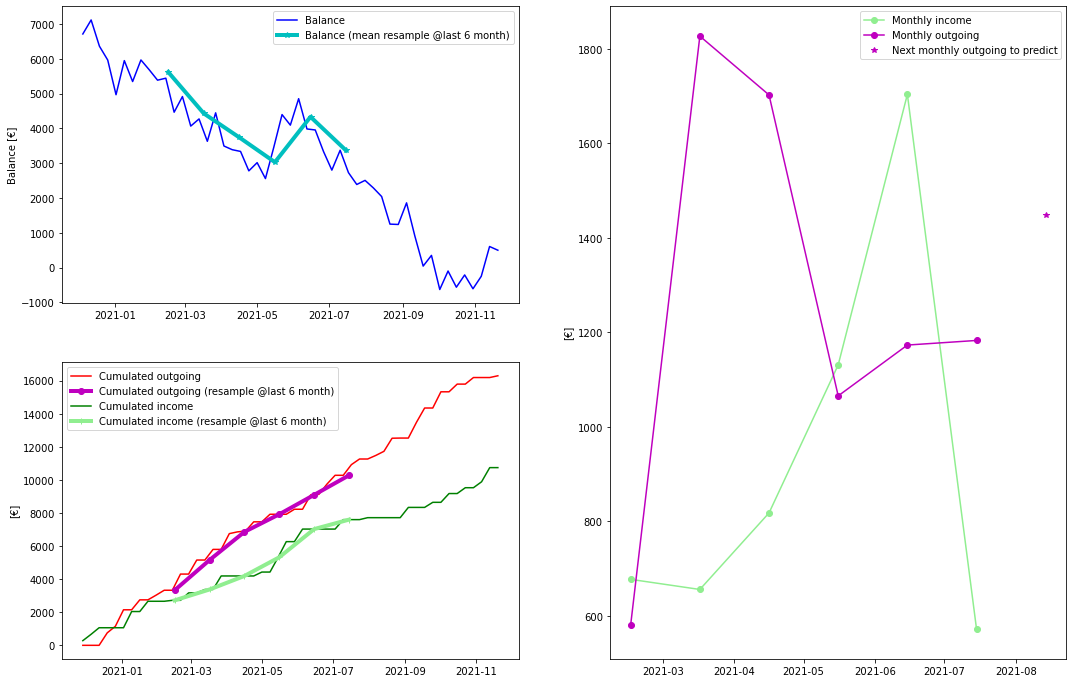

income_cumsum  outgoing_cumsum      balance  monthly_income  \
date                                                                      
2021-02-15    2720.654380      3330.771316  5621.403254      677.375712   
2021-03-17    3376.653510      5157.545462  4431.103229      655.999130   
2021-04-16    4194.583088      6859.887237  3740.842873      817.929578   
2021-05-16    5325.726504      7925.485587  3030.217413     1131.143415   
2021-06-15    7029.247035      9098.609866  4333.546643     1703.520531   
2021-07-15    7601.265093     10281.477657  3366.677320      572.018058   

            monthly_outgoing  
date                          
2021-02-15        581.211106  
2021-03-17       1826.774146  
2021-04-16       1702.341775  
2021-05-16       1065.598350  
2021-06-15       1173.124279  
2021-07-15       1182.867791

In [26]:
my_account_synthesis.get_last_6_month(np.datetime64('2021-07-15'))
print(my_account_synthesis)
my_account_synthesis.plot_last_6_month()
my_account_synthesis.last_6_month

 * Get and plot next monthly outgoing depending on analysis date (useful from testing prediction model) 

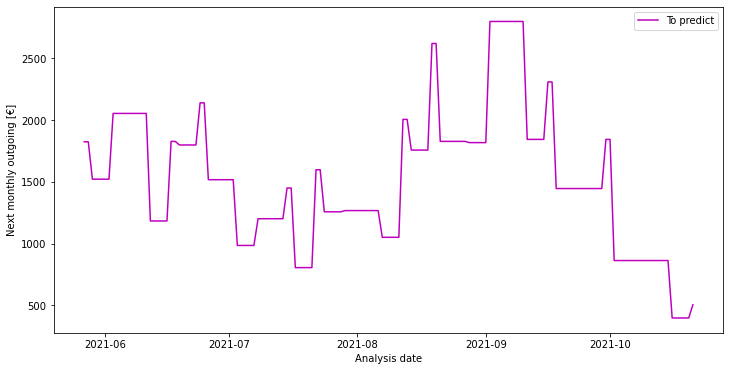

In [27]:
X_analysis_date, Y_next_monthly_outgoing = my_account_synthesis.monthly_outgoing_to_predict(True)